# <div align="center" style="color: #ff5733;">PSI and CSI Calculations</div>

# Declare Libraries

In [137]:
# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.

# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
path = r'C:\Users\DwaipayanChakroborti\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')

# %% [markdown]
## Configure Settings
# Set options or configurations as needed
# Example: pd.set_option('display.max_columns', None)

# Drop tables 

In [138]:
# Drop the table if exist

sq = """drop table if exists dap_ds_poweruser_playground.F_PSI_TT"""
client.query(sq)

sq = """drop table if exists dap_ds_poweruser_playground.F_CSI_TT"""

# Functions

## PSI Function - calculate_psi

In [139]:
def calculate_psi(expected, actual, buckets=10):
    def psi(e_perc, a_perc):
        # Avoid division by zero and log(0)
        if e_perc == 0:
            e_perc = 0.0000001
        if a_perc == 0:
            a_perc = 0.0000001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)
    
    # Remove null values and convert to numpy arrays
    expected = expected.dropna().values
    actual = actual.dropna().values
    
    # Ensure we have data to work with
    if len(expected) == 0 or len(actual) == 0:
        return np.nan
    
    # Calculate bucket boundaries
    breakpoints = np.linspace(0, 100, buckets + 1)
    bucket_bounds = np.percentile(np.concatenate([expected, actual]), breakpoints)
    
    # Assign data to buckets
    expected_counts, _ = np.histogram(expected, bins=bucket_bounds)
    actual_counts, _ = np.histogram(actual, bins=bucket_bounds)
    
    # Calculate percentages
    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)
    
    # Calculate PSI for each bucket
    psi_values = np.array([psi(e, a) for e, a in zip(expected_percents, actual_percents)])
    
    # Return total PSI
    return np.sum(psi_values)

## CSI Function - calculate_csi_credolabscore

In [140]:
import numpy as np
import pandas as pd

def calculate_csi_credolabscore(expected, actual):
    def csi(e_perc, a_perc):
        # Avoid division by zero and log(0)
        if e_perc == 0:
            e_perc = 0.0000001
        if a_perc == 0:
            a_perc = 0.0000001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)
    
    # Remove null values
    expected = expected.dropna()
    actual = actual.dropna()
    
    # Ensure we have data to work with
    if len(expected) == 0 or len(actual) == 0:
        return np.nan
    
    # Calculate percentages
    expected_percent = len(expected) / (len(expected) + len(actual))
    actual_percent = len(actual) / (len(expected) + len(actual))
    
    # Calculate CSI
    return csi(expected_percent, actual_percent)

## CSI Function - calculate_csi_monthlyIncome

In [141]:
def calculate_csi_monthlyIncome(expected, actual):
    def csi(e_perc, a_perc):
        # Avoid division by zero and log(0)
        if e_perc == 0:
            e_perc = 0.0000001
        if a_perc == 0:
            a_perc = 0.0000001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)
    
    # Remove null values
    expected = expected.dropna()
    actual = actual.dropna()
    
    # Ensure we have data to work with
    if len(expected) == 0 or len(actual) == 0:
        return np.nan
    
    # Calculate percentages
    expected_percent = len(expected) / (len(expected) + len(actual))
    actual_percent = len(actual) / (len(expected) + len(actual))
    
    # Calculate CSI
    return csi(expected_percent, actual_percent)

# Demographic Score

## New Demographic Score

`This score was implemented and productionized since April 2024`

### New Demographic Score 2024-04 for SIL Monthly

#### SQL Code

In [142]:
sq = """with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
,  demographicScore, credolabScore, credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, credolabscore_crif
from base 
where 
LoanProduct in ('SIL-Instore')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;"""

#### Run the above sql code

In [143]:
df = client.query(sq).to_dataframe()
df

,Application_month,Appl_week_start_date,Appl_week_number,LoanProduct,digitalLoanAccountId,demographicScore,credolabScore,credolabscore_crif
0,2024-04,2024-04-01,14,SIL-Instore,7208460a-1d88-4779-89a6-f63340e39988,425.0,None,None
1,2024-04,2024-04-01,14,SIL-Instore,6006d1a6-836d-4a1a-85fd-4499f6612799,451.0,444,444.0
2,2024-04,2024-04-01,14,SIL-Instore,5c79ea83-ccf5-4777-808f-6ca7423b06b7,465.0,442,442.0
3,2024-04,2024-04-01,14,SIL-Instore,b86816f0-442c-4576-aaaf-85c82cbbc717,439.0,335,335.0
4,2024-04,2024-04-01,14,SIL-Instore,78ccc82f-ae4a-4ea6-b369-dc6570f86c6c,464.0,462,462.0
...,...,...,...,...,...,...,...,...
67253,2024-07,2024-07-22,30,SIL-Instore,633933c0-674d-4da4-8091-1c7a7808d995,447.0,461.0,None
67254,2024-07,2024-07-22,30,SIL-Instore,e323d993-9a6f-4d18-a6a8-bbfac53ea7d5,442.0,413.0,None
67255,2024-07,2024-07-22,30,SIL-Instore,bb9bd0af-a546-4098-8aa8-dfc8b55a2dae,451.0,355.0,None
67256,2024-07,2024-07-22,30,SIL-Instore,1d4b70fb-10a8-4e6e-8122-02956dbcccf4,445.0,386.0,None


#### Calculate Monthly Demographic Score for SIL

In [144]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get the data for October 2024
April2024_data = df[df['year_month'] == '2024-04']['demographicScore']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate PSI for each month from September 2023 up to October 2024, compared to October 2024
    psi_results = []
    for name, group in df[(df['year_month'] >= '2024-04')].groupby('year_month'):
        if name == '2024-04':
            continue  # Skip October 2024 as we don't compare it with itself
        
        current_month = group['demographicScore']
        
        psi_value = calculate_psi(April2024_data, current_month)
        psi_results.append({'year_month': name, 'psi': psi_value})

    if not psi_results:
        print("No valid months found for comparison")
    else:
        psi_df = pd.DataFrame(psi_results)
        psi_df = psi_df.sort_values('year_month')  # Sort results by year_month
        # print(psi_df)
psi_df['Score_Category'] = 'Demographic_Score_2024-04'
psi_df['Date_Category'] = 'Monthly'
psi_df['Loan_Product'] = 'SIL'
psi_df['Dated'] = psi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
psi_df.drop(columns=['year_month'], inplace = True)
psi_df = psi_df[['Dated', 'Score_Category', 'Loan_Product', 'Date_Category', 'psi']]
psi_df['Dated'] = pd.to_datetime(psi_df['Dated'], format='%Y-%m-%d')
print(psi_df)

       Dated             Score_Category Loan_Product Date_Category       psi
0 2024-04-01  Demographic_Score_2024-04          SIL       Monthly  0.000000
1 2024-05-01  Demographic_Score_2024-04          SIL       Monthly  0.000751
2 2024-06-01  Demographic_Score_2024-04          SIL       Monthly  0.001768
3 2024-07-01  Demographic_Score_2024-04          SIL       Monthly  0.001393


#### Create the Table F_PSI_TT

In [145]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_PSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("psi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(psi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_PSI_TT created in dataset dap_ds_poweruser_playground.


#### Calculate Weekly Demographic Score PSI for SIL

In [146]:
# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])

# # Create a 'year_week' column
# df['year_week'] = df['Appl_week_start_date'].dt.to_period('W-MON')

# df.info()

# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']['demographicScore']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate PSI for each month from September 2023 up to October 2024, compared to October 2024
    psi_results = []
    for name, group in df[(df['Appl_week_start_date'] >= '2024-04-01')].groupby('Appl_week_start_date'):
        if name == '2024-04-01':
            continue  # Skip October 2024 as we don't compare it with itself
        
        current_month = group['demographicScore']
        
        psi_value = calculate_psi(April2024_data, current_month)
        psi_results.append({'Appl_week_start_date': name, 'psi': psi_value})

    if not psi_results:
        print("No valid months found for comparison")
    else:
        psi_df = pd.DataFrame(psi_results)
        psi_df = psi_df.sort_values('Appl_week_start_date')  # Sort results by year_month
        # print(psi_df)
psi_df['Score_Category'] = 'Demographic_Score_2024-04'
psi_df['Date_Category'] = 'Weekly'
psi_df['Loan_Product'] = 'SIL'
psi_df['Dated'] = psi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
psi_df.drop(columns=['Appl_week_start_date'], inplace = True)
psi_df = psi_df[['Dated', 'Score_Category', 'Loan_Product','Date_Category', 'psi']]
psi_df['Dated'] = pd.to_datetime(psi_df['Dated'], format='%Y-%m-%d')
print(psi_df)

        Dated             Score_Category Loan_Product Date_Category       psi
0  2024-04-01  Demographic_Score_2024-04          SIL        Weekly  0.000000
1  2024-04-08  Demographic_Score_2024-04          SIL        Weekly  0.013300
2  2024-04-15  Demographic_Score_2024-04          SIL        Weekly  0.021144
3  2024-04-22  Demographic_Score_2024-04          SIL        Weekly  0.018332
4  2024-04-29  Demographic_Score_2024-04          SIL        Weekly  0.016048
5  2024-05-06  Demographic_Score_2024-04          SIL        Weekly  0.018597
6  2024-05-13  Demographic_Score_2024-04          SIL        Weekly  0.008042
7  2024-05-20  Demographic_Score_2024-04          SIL        Weekly  0.010146
8  2024-05-27  Demographic_Score_2024-04          SIL        Weekly  0.017808
9  2024-06-03  Demographic_Score_2024-04          SIL        Weekly  0.011747
10 2024-06-10  Demographic_Score_2024-04          SIL        Weekly  0.013689
11 2024-06-17  Demographic_Score_2024-04          SIL        Wee

#### Insert into table F_PSI_TT

In [147]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_PSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("psi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(psi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_PSI_TT created in dataset dap_ds_poweruser_playground.


### New Demographic Score 2024-04 Onwards for Cash Loans Monthly

#### SQL Code

In [148]:
sq = """with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
,  demographicScore, credolabScore, credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, credolabscore_crif
from base 
where 
LoanProduct in ('Quick', 'Flex')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 
 order by 1,2,3
 ;"""

#### Run the above sql code

In [149]:
df = client.query(sq).to_dataframe()

#### Calculate Monthly Demographic Score PSI for Cash Loan

In [150]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get the data for October 2024
April2024_data = df[df['year_month'] == '2024-04']['demographicScore']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate PSI for each month from September 2023 up to October 2024, compared to October 2024
    psi_results = []
    for name, group in df[(df['year_month'] >= '2024-04')].groupby('year_month'):
        if name == '2024-04':
            continue  # Skip October 2024 as we don't compare it with itself
        
        current_month = group['demographicScore']
        
        psi_value = calculate_psi(April2024_data, current_month)
        psi_results.append({'year_month': name, 'psi': psi_value})

    if not psi_results:
        print("No valid months found for comparison")
    else:
        psi_df = pd.DataFrame(psi_results)
        psi_df = psi_df.sort_values('year_month')  # Sort results by year_month
        # print(psi_df)
psi_df['Score_Category'] = 'Demographic_Score_2024-04'
psi_df['Date_Category'] = 'Monthly'
psi_df['Loan_Product'] = 'Cash Loan'
psi_df['Dated'] = psi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
psi_df.drop(columns=['year_month'], inplace = True)
psi_df = psi_df[['Dated', 'Score_Category','Loan_Product','Date_Category', 'psi']]
psi_df['Dated'] = pd.to_datetime(psi_df['Dated'], format='%Y-%m-%d')
# print(psi_df)

#### Insert to table F_PSI_TT

In [151]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_PSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("psi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(psi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_PSI_TT created in dataset dap_ds_poweruser_playground.


#### Calculate Weekly Demographic Score PSI for Cash Loan

In [152]:
# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])

# # Create a 'year_week' column
# df['year_week'] = df['Appl_week_start_date'].dt.to_period('W-MON')

# df.info()

# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']['demographicScore']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate PSI for each month from September 2023 up to October 2024, compared to October 2024
    psi_results = []
    for name, group in df[(df['Appl_week_start_date'] >= '2024-04-01')].groupby('Appl_week_start_date'):
        if name == '2024-04-01':
            continue  # Skip October 2024 as we don't compare it with itself
        
        current_month = group['demographicScore']
        
        psi_value = calculate_psi(April2024_data, current_month)
        psi_results.append({'Appl_week_start_date': name, 'psi': psi_value})

    if not psi_results:
        print("No valid months found for comparison")
    else:
        psi_df = pd.DataFrame(psi_results)
        psi_df = psi_df.sort_values('Appl_week_start_date')  # Sort results by year_month
        # print(psi_df)
psi_df['Score_Category'] = 'Demographic_Score_2024-04'
psi_df['Date_Category'] = 'Weekly'
psi_df['Loan_Product'] = 'Cash Loan'
psi_df['Dated'] = psi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
psi_df.drop(columns=['Appl_week_start_date'], inplace = True)
psi_df = psi_df[['Dated', 'Score_Category', 'Loan_Product','Date_Category', 'psi']]
psi_df['Dated'] = pd.to_datetime(psi_df['Dated'], format='%Y-%m-%d')
# print(psi_df)

#### Insert into table f_psi_tt

In [153]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_PSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("psi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(psi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_PSI_TT created in dataset dap_ds_poweruser_playground.


## Old Demographic Score

### Demographic Score Old (2023-05 to 2024-03) Monthly for Cash Loan And SIL

#### SQL Code

In [154]:
sq = """
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
,  demographicScore, credolabScore, credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) >='2023-05-17' and date_trunc(startApplyDateTime, day) <= '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, credolabscore_crif
from base 
where 
LoanProduct in ('Flex', 'Quick', 'SIL-Instore')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 """

#### Run the sql code

In [155]:
df = client.query(sq).to_dataframe()

#### Old Demographic Score PSI calculation - Monthly

In [156]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get the data for October 2024
ref_data = df[df['year_month'] == '2023-05']['demographicScore']

# Check if April 2024 data exists
if ref_data.empty:
    print("Error: No data found for May 2023")
else:
    # Calculate PSI for each month from September 2023 up to October 2024, compared to October 2024
    psi_results = []
    for name, group in df[(df['year_month'] >= '2023-05')].groupby('year_month'):
        if name == '2023-05':
            continue  # Skip October 2024 as we don't compare it with itself
        
        current_month = group['demographicScore']
        
        psi_value = calculate_psi(ref_data, current_month)
        psi_results.append({'year_month': name, 'psi': psi_value})

    if not psi_results:
        print("No valid months found for comparison")
    else:
        psi_df = pd.DataFrame(psi_results)
        psi_df = psi_df.sort_values('year_month')  # Sort results by year_month
        # print(psi_df)
psi_df['Score_Category'] = 'Demographic_Score_2023-05_2024-03'
psi_df['Date_Category'] = 'Monthly'
psi_df['Loan_Product'] = 'Cash Loan & SIL'
psi_df['Dated'] = psi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
psi_df.drop(columns=['year_month'], inplace = True)
psi_df = psi_df[['Dated', 'Score_Category','Loan_Product','Date_Category', 'psi']]
psi_df['Dated'] = pd.to_datetime(psi_df['Dated'], format='%Y-%m-%d')


#### Insert into table f_psi_tt

In [157]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_PSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("psi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(psi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_PSI_TT created in dataset dap_ds_poweruser_playground.


#### Demographic_Score_2023-05_2024-03 PSI Calculation Weekly for Cash Loan and SIL

In [158]:
# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])

# # Create a 'year_week' column
# df['year_week'] = df['Appl_week_start_date'].dt.to_period('W-MON')

# df.info()

# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get the data for April 2024
Ref_data = df[df['Appl_week_start_date'] == '2023-05-15']['demographicScore']

# Check if April 2024 data exists
if Ref_data.empty:
    print("Error: No data found for '2023-05-15'")
else:
    # Calculate PSI for each month from September 2023 up to October 2024, compared to October 2024
    psi_results = []
    for name, group in df[(df['Appl_week_start_date'] >= '2023-05-15')].groupby('Appl_week_start_date'):
        if name == '2023-05-15':
            continue  # Skip October 2024 as we don't compare it with itself
        
        current_month = group['demographicScore']
        
        psi_value = calculate_psi(Ref_data, current_month)
        psi_results.append({'Appl_week_start_date': name, 'psi': psi_value})

    if not psi_results:
        print("No valid months found for comparison")
    else:
        psi_df = pd.DataFrame(psi_results)
        psi_df = psi_df.sort_values('Appl_week_start_date')  # Sort results by year_month
        # print(psi_df)
psi_df['Score_Category'] = 'Demographic_Score_2023-05_2024-03'
psi_df['Date_Category'] = 'Weekly'
psi_df['Loan_Product'] = 'Cash Loan & SIL'
psi_df['Dated'] = psi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
psi_df.drop(columns=['Appl_week_start_date'], inplace = True)
psi_df = psi_df[['Dated', 'Score_Category', 'Loan_Product','Date_Category', 'psi']]
psi_df['Dated'] = pd.to_datetime(psi_df['Dated'], format='%Y-%m-%d')


#### Insert into table f_psi_tt

In [159]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_PSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("psi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(psi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_PSI_TT created in dataset dap_ds_poweruser_playground.


# CSI

## New Demographic Score Features

### CredoLabScore

#### CredoLab Score Feature for New Demographic Score For Product SIL 

##### SQL Code

In [160]:
sq = """
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
, demographicScore
,  credolabScore
, case when cast(credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(credolabScore as float64) > 450.5 and cast(credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(credolabScore as float64) > 460.5 and cast(credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(credolabScore as float64) is null then 'e. nan' end Credolab_Score_band,
credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif
from base 
where 
LoanProduct in ('SIL-Instore')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 """

##### Run the sql code

In [161]:
df = client.query(sq).to_dataframe()


In [162]:
df['credolabScore'] = df['credolabScore'].fillna(-1)
df['credolabScore'] = df['credolabScore'].astype(np.float64)

##### CredoLabScore Characteristic Stability Index (CSI) Monthly for SIL

In [163]:


# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique credolabscorebands
credolabscorebands = sorted(df['Credolab_Score_band'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each credolabScoreband, comparing April 2024 with each subsequent month
    csi_results = []
    for scoreband in credolabscorebands:
        April2024_scoreband = April2024_data[April2024_data['Credolab_Score_band'] == scoreband]['credolabScore']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_scoreband = group[group['Credolab_Score_band'] == scoreband]['credolabScore']
            
            csi_value = calculate_csi_credolabscore(April2024_scoreband, current_month_scoreband)
            
            csi_results.append({
                'year_month': name,
                'credolabscoreband': f'({scoreband}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['credolabscoreband', 'year_month'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# # If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='credolabscoreband', columns='year_month', values='csi')
pivot_df

   year_month    credolabscoreband       csi
0     2024-05   (a. [-inf, 450.5)]  0.005649
1     2024-06   (a. [-inf, 450.5)]  0.025783
2     2024-07   (a. [-inf, 450.5)]  0.000846
3     2024-05  (b. [450.5, 460.5)]  0.007854
4     2024-06  (b. [450.5, 460.5)]  0.007216
5     2024-07  (b. [450.5, 460.5)]  0.013581
6     2024-05  (c. [460.5, 528.5)]  0.006956
7     2024-06  (c. [460.5, 528.5)]  0.022243
8     2024-07  (c. [460.5, 528.5)]  0.014550
9     2024-05    (d. [528.5, inf)]  0.075430
10    2024-06    (d. [528.5, inf)]  0.123465
11    2024-07    (d. [528.5, inf)]  0.012827
12    2024-05             (e. nan]  0.000056
13    2024-06             (e. nan]  0.006400
14    2024-07             (e. nan]  0.018979


year_month,2024-05,2024-06,2024-07
credolabscoreband,,,
"(a. [-inf, 450.5)]",0.005649,0.025783,0.000846
"(b. [450.5, 460.5)]",0.007854,0.007216,0.013581
"(c. [460.5, 528.5)]",0.006956,0.022243,0.014550
"(d. [528.5, inf)]",0.075430,0.123465,0.012827
(e. nan],0.000056,0.006400,0.018979


In [164]:
csi_df['Score_Category'] = 'CredolabScore - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'CredolabScore'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'credolabscoreband', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'credolabscoreband':'Band'}, inplace = True)
# csi_df

##### Create F_CSI_TT table

In [165]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_CSI_TT created in dataset dap_ds_poweruser_playground.


##### CredoLabScore Characteristic Stability Index (CSI) Weekly For SIL

In [166]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique credolabscorebands
credolabscorebands = sorted(df['Credolab_Score_band'].unique())

# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each credolabScoreband, comparing April 2024 with each subsequent month
    csi_results = []
    for scoreband in credolabscorebands:
        April2024_scoreband = April2024_data[April2024_data['Credolab_Score_band'] == scoreband]['credolabScore']
        
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_scoreband = group[group['Credolab_Score_band'] == scoreband]['credolabScore']
            
            csi_value = calculate_csi_credolabscore(April2024_scoreband, current_month_scoreband)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'credolabscoreband': f'({scoreband}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['credolabscoreband', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='credolabscoreband', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date   credolabscoreband       csi
0            2024-04-08  (a. [-inf, 450.5)]  0.007831
1            2024-04-15  (a. [-inf, 450.5)]  0.050880
2            2024-04-22  (a. [-inf, 450.5)]  0.161966
3            2024-04-29  (a. [-inf, 450.5)]  0.214309
4            2024-05-06  (a. [-inf, 450.5)]  0.058356
..                  ...                 ...       ...
75           2024-06-24            (e. nan]  0.075916
76           2024-07-01            (e. nan]  0.071295
77           2024-07-08            (e. nan]  0.079672
78           2024-07-15            (e. nan]  0.087329
79           2024-07-22            (e. nan]  0.723284

[80 rows x 3 columns]


Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
credolabscoreband,,,,,,,,,,,,,,,,
"(a. [-inf, 450.5)]",0.007831,0.050880,0.161966,0.214309,0.058356,0.056261,0.039043,0.097908,0.108556,0.153880,0.109651,0.161628,0.145866,0.145036,0.163829,0.463829
"(b. [450.5, 460.5)]",0.013096,0.079117,0.191118,0.239118,0.065059,0.091168,0.061369,0.067555,0.092535,0.110746,0.098052,0.050712,0.109317,0.117950,0.091168,0.659719
"(c. [460.5, 528.5)]",0.000261,0.017778,0.153500,0.169080,0.047998,0.084453,0.013686,0.055426,0.086302,0.114520,0.067179,0.083840,0.033350,0.064318,0.115182,0.843923
"(d. [528.5, inf)]",0.115597,0.050282,0.050282,0.152622,0.191316,0.231049,0.271358,0.231049,0.191316,0.191316,0.352406,0.392696,0.008902,0.586981,0.311896,0.231049
(e. nan],0.001052,0.049564,0.190890,0.173973,0.024000,0.032015,0.010847,0.062313,0.030620,0.080619,0.112365,0.075916,0.071295,0.079672,0.087329,0.723284


In [167]:
csi_df['Score_Category'] = 'CredolabScore - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'CredolabScore'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'credolabscoreband', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'credolabscoreband':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,CredolabScore - Demographic Score 2024,SIL,CredolabScore,"(a. [-inf, 450.5)]",Weekly,0.007831
1,2024-04-15,CredolabScore - Demographic Score 2024,SIL,CredolabScore,"(a. [-inf, 450.5)]",Weekly,0.050880
2,2024-04-22,CredolabScore - Demographic Score 2024,SIL,CredolabScore,"(a. [-inf, 450.5)]",Weekly,0.161966
3,2024-04-29,CredolabScore - Demographic Score 2024,SIL,CredolabScore,"(a. [-inf, 450.5)]",Weekly,0.214309
4,2024-05-06,CredolabScore - Demographic Score 2024,SIL,CredolabScore,"(a. [-inf, 450.5)]",Weekly,0.058356
...,...,...,...,...,...,...,...
75,2024-06-24,CredolabScore - Demographic Score 2024,SIL,CredolabScore,(e. nan],Weekly,0.075916
76,2024-07-01,CredolabScore - Demographic Score 2024,SIL,CredolabScore,(e. nan],Weekly,0.071295
77,2024-07-08,CredolabScore - Demographic Score 2024,SIL,CredolabScore,(e. nan],Weekly,0.079672
78,2024-07-15,CredolabScore - Demographic Score 2024,SIL,CredolabScore,(e. nan],Weekly,0.087329


##### Insert into table F_CSI_TT

In [168]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

print(f"Table {table_id} created in dataset {dataset_id}.")

Table F_CSI_TT created in dataset dap_ds_poweruser_playground.


#### CredoLab Score Feature for New Demographic Score For Product Cashloan

##### SQL Code

In [169]:
sq = """
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
, demographicScore
,  credolabScore
, case when cast(credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(credolabScore as float64) > 450.5 and cast(credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(credolabScore as float64) > 460.5 and cast(credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(credolabScore as float64) is null then 'e. nan' end Credolab_Score_band,
credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif
from base 
where 
LoanProduct in ('Quick', 'Flex')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 """

##### Run the SQL Code

In [170]:
df = client.query(sq).to_dataframe()

In [171]:
df['credolabScore'] = df['credolabScore'].fillna(-1)
df['credolabScore'] = df['credolabScore'].astype(np.float64)

##### CredoLabScore Characteristic Stability Index (CSI) Monthly for Cash Loan

In [172]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique credolabscorebands
credolabscorebands = sorted(df['Credolab_Score_band'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each credolabScoreband, comparing April 2024 with each subsequent month
    csi_results = []
    for scoreband in credolabscorebands:
        April2024_scoreband = April2024_data[April2024_data['Credolab_Score_band'] == scoreband]['credolabScore']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_scoreband = group[group['Credolab_Score_band'] == scoreband]['credolabScore']
            
            csi_value = calculate_csi_credolabscore(April2024_scoreband, current_month_scoreband)
            
            csi_results.append({
                'year_month': name,
                'credolabscoreband': f'({scoreband}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['credolabscoreband', 'year_month'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='credolabscoreband', columns='year_month', values='csi')
pivot_df

   year_month    credolabscoreband       csi
0     2024-05   (a. [-inf, 450.5)]  0.042331
1     2024-06   (a. [-inf, 450.5)]  0.805201
2     2024-07   (a. [-inf, 450.5)]  0.820847
3     2024-05  (b. [450.5, 460.5)]  0.033676
4     2024-06  (b. [450.5, 460.5)]  0.619366
5     2024-07  (b. [450.5, 460.5)]  0.472295
6     2024-05  (c. [460.5, 528.5)]  0.014775
7     2024-06  (c. [460.5, 528.5)]  0.432790
8     2024-07  (c. [460.5, 528.5)]  0.253869
9     2024-05    (d. [528.5, inf)]  0.006801
10    2024-06    (d. [528.5, inf)]  0.042499
11    2024-07    (d. [528.5, inf)]  0.004084
12    2024-05             (e. nan]  0.008692
13    2024-06             (e. nan]  0.141208
14    2024-07             (e. nan]  0.235120


year_month,2024-05,2024-06,2024-07
credolabscoreband,,,
"(a. [-inf, 450.5)]",0.042331,0.805201,0.820847
"(b. [450.5, 460.5)]",0.033676,0.619366,0.472295
"(c. [460.5, 528.5)]",0.014775,0.432790,0.253869
"(d. [528.5, inf)]",0.006801,0.042499,0.004084
(e. nan],0.008692,0.141208,0.235120


In [173]:
csi_df['Score_Category'] = 'CredolabScore - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'CredolabScore'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'credolabscoreband', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'credolabscoreband':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(a. [-inf, 450.5)]",Monthly,0.042331
1,2024-06-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(a. [-inf, 450.5)]",Monthly,0.805201
2,2024-07-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(a. [-inf, 450.5)]",Monthly,0.820847
3,2024-05-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(b. [450.5, 460.5)]",Monthly,0.033676
4,2024-06-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(b. [450.5, 460.5)]",Monthly,0.619366
5,2024-07-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(b. [450.5, 460.5)]",Monthly,0.472295
6,2024-05-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(c. [460.5, 528.5)]",Monthly,0.014775
7,2024-06-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(c. [460.5, 528.5)]",Monthly,0.432790
8,2024-07-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(c. [460.5, 528.5)]",Monthly,0.253869
9,2024-05-01,CredolabScore - Demographic Score 2024,Cash Loan,CredolabScore,"(d. [528.5, inf)]",Monthly,0.006801


##### Insert into table 'F_CSI_TT'

In [174]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=ca8007b7-801c-401f-b693-5f0f88827dec>

##### CredoLabScore Characteristic Stability Index (CSI) Weekly for Cash Loan

In [175]:
# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])

# # Create a 'year_week' column
# df['year_week'] = df['Appl_week_start_date'].dt.to_period('W-MON')

# df.info()

# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique credolabscorebands
credolabscorebands = sorted(df['Credolab_Score_band'].unique())

# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each credolabScoreband, comparing April 2024 with each subsequent month
    csi_results = []
    for scoreband in credolabscorebands:
        April2024_scoreband = April2024_data[April2024_data['Credolab_Score_band'] == scoreband]['credolabScore']
        
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_scoreband = group[group['Credolab_Score_band'] == scoreband]['credolabScore']
            
            csi_value = calculate_csi_credolabscore(April2024_scoreband, current_month_scoreband)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'credolabscoreband': f'({scoreband}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['credolabscoreband', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='credolabscoreband', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date   credolabscoreband       csi
0            2024-04-08  (a. [-inf, 450.5)]  0.002560
1            2024-04-15  (a. [-inf, 450.5)]  0.002419
2            2024-04-22  (a. [-inf, 450.5)]  0.017230
3            2024-04-29  (a. [-inf, 450.5)]  0.056079
4            2024-05-06  (a. [-inf, 450.5)]  0.051080
..                  ...                 ...       ...
75           2024-06-24            (e. nan]  0.164956
76           2024-07-01            (e. nan]  0.311896
77           2024-07-08            (e. nan]  0.344018
78           2024-07-15            (e. nan]  0.366736
79           2024-07-22            (e. nan]  0.085728

[80 rows x 3 columns]


Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
credolabscoreband,,,,,,,,,,,,,,,,
"(a. [-inf, 450.5)]",0.002560,0.002419,0.017230,0.056079,0.051080,4.695232e-02,0.042710,0.129287,0.437657,0.893959,1.111480,1.183538,1.182208,1.156014,1.218117,0.190048
"(b. [450.5, 460.5)]",0.002107,0.000073,0.000645,0.006002,0.037688,5.097808e-02,0.038954,0.073184,0.347475,0.680412,0.839712,0.849182,0.802887,0.735162,0.711414,0.010808
"(c. [460.5, 528.5)]",0.000001,0.001607,0.002764,0.014850,0.019169,3.192239e-02,0.002842,0.026286,0.234258,0.493424,0.542710,0.580997,0.477823,0.442138,0.504290,0.049827
"(d. [528.5, inf)]",0.001271,0.000343,0.004101,0.001271,0.000037,2.952995e-02,0.000000,0.012624,0.038079,0.119327,0.031176,0.039881,0.015042,0.000037,0.087973,0.642766
(e. nan],0.008470,0.008815,0.023973,0.000272,0.000003,6.628731e-07,0.005846,0.000313,0.000011,0.093769,0.202403,0.164956,0.311896,0.344018,0.366736,0.085728


In [176]:
csi_df['Score_Category'] = 'CredolabScore - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'CredolabScore'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'credolabscoreband', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'credolabscoreband':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
# csi_df

##### Insert into table F_CSI_TT

In [177]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=2500d57d-be69-40b9-9f47-a4de10f54b40>

### Monthly Income

#### Monthly Income For SIL

##### SQL Code

In [178]:
sq = """
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
, demographicScore
,  credolabScore
, case when cast(credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(credolabScore as float64) > 450.5 and cast(credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(credolabScore as float64) > 460.5 and cast(credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, monthlyIncome
,CASE
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin,
credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome

from base 
where 
LoanProduct in ('SIL-Instore')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 """

##### Run the code

In [179]:
df = client.query(sq).to_dataframe()

In [180]:
df['monthlyIncome'] = df['monthlyIncome'].fillna(-1)
df['monthlyIncome'] = df['monthlyIncome'].astype(np.float64)

##### Monthly Income Characteristic Stability Index (CSI) Monthly For SIL

In [181]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
income_bins = sorted(df['monthlyIncomeBin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for income_bin in income_bins:
        April2024_bin = April2024_data[April2024_data['monthlyIncomeBin'] == income_bin]['monthlyIncome']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['monthlyIncomeBin'] == income_bin]['monthlyIncome']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'monthlyIncomeBin': income_bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['monthlyIncomeBin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='year_month', values='csi')
print(pivot_df)

  year_month   monthlyIncomeBin       csi
0    2024-05      a. (0, 25000]  0.006908
1    2024-06      a. (0, 25000]  0.044085
2    2024-07      a. (0, 25000]  0.000156
3    2024-05  b. (25000, 51167]  0.003418
4    2024-06  b. (25000, 51167]  0.004488
5    2024-07  b. (25000, 51167]  0.022232
6    2024-05    c. (51167, Inf]  0.003032
7    2024-06    c. (51167, Inf]  0.002642
8    2024-07    c. (51167, Inf]  0.021747
year_month          2024-05   2024-06   2024-07
monthlyIncomeBin                               
a. (0, 25000]      0.006908  0.044085  0.000156
b. (25000, 51167]  0.003418  0.004488  0.022232
c. (51167, Inf]    0.003032  0.002642  0.021747


In [182]:
csi_df['Score_Category'] = 'Monthly Income - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'Monthly Income'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'monthlyIncomeBin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'monthlyIncomeBin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"a. (0, 25000]",Monthly,0.006908
1,2024-06-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"a. (0, 25000]",Monthly,0.044085
2,2024-07-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"a. (0, 25000]",Monthly,0.000156
3,2024-05-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"b. (25000, 51167]",Monthly,0.003418
4,2024-06-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"b. (25000, 51167]",Monthly,0.004488
5,2024-07-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"b. (25000, 51167]",Monthly,0.022232
6,2024-05-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"c. (51167, Inf]",Monthly,0.003032
7,2024-06-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"c. (51167, Inf]",Monthly,0.002642
8,2024-07-01,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"c. (51167, Inf]",Monthly,0.021747


##### Insert into F_CSI_TT

In [183]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=1d51bca1-6164-470a-849f-a5cb0ff8fca4>

##### Monthly Income Characteristic Stability Index (CSI) Weekly For SIL

In [184]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
income_bins = sorted(df['monthlyIncomeBin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for income_bin in income_bins:
        April2024_bin = April2024_data[April2024_data['monthlyIncomeBin'] == income_bin]['monthlyIncome']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['monthlyIncomeBin'] == income_bin]['monthlyIncome']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'monthlyIncomeBin': f'({income_bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['monthlyIncomeBin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date     monthlyIncomeBin       csi
0            2024-04-08      (a. (0, 25000]]  0.011049
1            2024-04-15      (a. (0, 25000]]  0.072519
2            2024-04-22      (a. (0, 25000]]  0.191259
3            2024-04-29      (a. (0, 25000]]  0.238673
4            2024-05-06      (a. (0, 25000]]  0.070146
5            2024-05-13      (a. (0, 25000]]  0.069240
6            2024-05-20      (a. (0, 25000]]  0.058127
7            2024-05-27      (a. (0, 25000]]  0.143383
8            2024-06-03      (a. (0, 25000]]  0.147718
9            2024-06-10      (a. (0, 25000]]  0.208312
10           2024-06-17      (a. (0, 25000]]  0.170607
11           2024-06-24      (a. (0, 25000]]  0.223906
12           2024-07-01      (a. (0, 25000]]  0.183364
13           2024-07-08      (a. (0, 25000]]  0.198287
14           2024-07-15      (a. (0, 25000]]  0.237054
15           2024-07-22      (a. (0, 25000]]  0.402917
16           2024-04-08  (b. (25000, 51167]]  0.003295
17        

Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
monthlyIncomeBin,,,,,,,,,,,,,,,,
"(a. (0, 25000]]",0.011049,0.072519,0.191259,0.238673,0.070146,0.069240,0.058127,0.143383,0.147718,0.208312,0.170607,0.223906,0.183364,0.198287,0.237054,0.402917
"(b. (25000, 51167]]",0.003295,0.029946,0.139120,0.185075,0.046005,0.058145,0.013096,0.035027,0.051095,0.074989,0.045635,0.059952,0.057945,0.059348,0.063822,0.760128
"(c. (51167, Inf]]",0.009562,0.000094,0.137773,0.058015,0.000091,0.012309,0.011414,0.034086,0.022721,0.032740,0.022721,0.000023,0.014183,0.031414,0.014183,0.650487


In [185]:
csi_df['Score_Category'] = 'Monthly Income - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'Monthly Income'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'monthlyIncomeBin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'monthlyIncomeBin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.011049
1,2024-04-15,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.072519
2,2024-04-22,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.191259
3,2024-04-29,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.238673
4,2024-05-06,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.070146
5,2024-05-13,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.069240
6,2024-05-20,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.058127
7,2024-05-27,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.143383
8,2024-06-03,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.147718
9,2024-06-10,Monthly Income - Demographic Score 2024,SIL,Monthly Income,"(a. (0, 25000]]",Weekly,0.208312


##### Insert into F_CSI_TT

In [186]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=a81ad228-a55c-4934-9cf7-9c00abb5827b>

#### Monthly Income For Cash Loan

##### SQLCode

In [187]:
sq = """
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
, demographicScore
,  credolabScore
, case when cast(credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(credolabScore as float64) > 450.5 and cast(credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(credolabScore as float64) > 460.5 and cast(credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, monthlyIncome
,CASE
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin,
credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome

from base 
where 
LoanProduct in ('Quick', 'Flex')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 """

##### Run the code

In [188]:
df = client.query(sq).to_dataframe()

In [189]:
df['monthlyIncome'] = df['monthlyIncome'].fillna(-1)
df['monthlyIncome'] = df['monthlyIncome'].astype(np.float64)

##### Monthly Income Characteristic Stability Index (CSI) Monthly For Cash Loan

In [190]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
income_bins = sorted(df['monthlyIncomeBin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for income_bin in income_bins:
        April2024_bin = April2024_data[April2024_data['monthlyIncomeBin'] == income_bin]['monthlyIncome']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['monthlyIncomeBin'] == income_bin]['monthlyIncome']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'monthlyIncomeBin': income_bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['monthlyIncomeBin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        # print(csi_df)

# If you want to pivot the results for easier viewing
# pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='year_month', values='csi')
# print(pivot_df)

In [191]:
csi_df['Score_Category'] = 'Monthly Income - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'Monthly Income'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'monthlyIncomeBin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'monthlyIncomeBin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"a. (0, 25000]",Monthly,0.023821
1,2024-06-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"a. (0, 25000]",Monthly,0.562682
2,2024-07-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"a. (0, 25000]",Monthly,0.573692
3,2024-05-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"b. (25000, 51167]",Monthly,0.020854
4,2024-06-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"b. (25000, 51167]",Monthly,0.421334
5,2024-07-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"b. (25000, 51167]",Monthly,0.363728
6,2024-05-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"c. (51167, Inf]",Monthly,0.019460
7,2024-06-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"c. (51167, Inf]",Monthly,0.403848
8,2024-07-01,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"c. (51167, Inf]",Monthly,0.342909


##### Insert into F_CSI_TT

In [192]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=0ae26711-2274-4d73-95a1-468f37283999>

##### Monthly Income Characteristic Stability Index (CSI) Weekly For Cash Loan

In [193]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
income_bins = sorted(df['monthlyIncomeBin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for income_bin in income_bins:
        April2024_bin = April2024_data[April2024_data['monthlyIncomeBin'] == income_bin]['monthlyIncome']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['monthlyIncomeBin'] == income_bin]['monthlyIncome']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'monthlyIncomeBin': f'({income_bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['monthlyIncomeBin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date     monthlyIncomeBin       csi
0            2024-04-08      (a. (0, 25000]]  0.000025
1            2024-04-15      (a. (0, 25000]]  0.000176
2            2024-04-22      (a. (0, 25000]]  0.000341
3            2024-04-29      (a. (0, 25000]]  0.013485
4            2024-05-06      (a. (0, 25000]]  0.018700
5            2024-05-13      (a. (0, 25000]]  0.020431
6            2024-05-20      (a. (0, 25000]]  0.008339
7            2024-05-27      (a. (0, 25000]]  0.054635
8            2024-06-03      (a. (0, 25000]]  0.236786
9            2024-06-10      (a. (0, 25000]]  0.597871
10           2024-06-17      (a. (0, 25000]]  0.750754
11           2024-06-24      (a. (0, 25000]]  0.786972
12           2024-07-01      (a. (0, 25000]]  0.827295
13           2024-07-08      (a. (0, 25000]]  0.811510
14           2024-07-15      (a. (0, 25000]]  0.866462
15           2024-07-22      (a. (0, 25000]]  0.030765
16           2024-04-08  (b. (25000, 51167]]  0.000495
17        

Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
monthlyIncomeBin,,,,,,,,,,,,,,,,
"(a. (0, 25000]]",0.000025,0.000176,0.000341,0.013485,0.018700,0.020431,0.008339,0.054635,0.236786,0.597871,0.750754,0.786972,0.827295,0.811510,0.866462,0.030765
"(b. (25000, 51167]]",0.000495,0.000228,0.000849,0.016292,0.016575,0.015871,0.005080,0.028333,0.161294,0.429452,0.557569,0.585543,0.575977,0.546736,0.615366,0.002110
"(c. (51167, Inf]]",0.000171,0.000178,0.000011,0.008065,0.004378,0.051082,0.004784,0.031285,0.117279,0.380679,0.591514,0.610926,0.564878,0.598468,0.554981,0.013088


In [194]:
csi_df['Score_Category'] = 'Monthly Income - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'Monthly Income'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'monthlyIncomeBin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'monthlyIncomeBin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.000025
1,2024-04-15,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.000176
2,2024-04-22,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.000341
3,2024-04-29,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.013485
4,2024-05-06,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.018700
5,2024-05-13,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.020431
6,2024-05-20,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.008339
7,2024-05-27,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.054635
8,2024-06-03,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.236786
9,2024-06-10,Monthly Income - Demographic Score 2024,Cash Loan,Monthly Income,"(a. (0, 25000]]",Weekly,0.597871


##### Insert into F_CSI_TT

In [195]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=4ee38691-1692-413d-bb9d-8afd315fb617>

### Telco Name

#### Telco Name for Cash Loan

##### SQLCode

In [196]:
sq = """
WITH prefix_mapping AS (
  SELECT 813 AS prefix, "Smart or Talk N Text" AS telco_name UNION ALL
  SELECT 817, "Globe or TM" UNION ALL
  SELECT 904, "Globe or TM" UNION ALL
  SELECT 905, "Globe or TM" UNION ALL
  SELECT 906, "Globe or TM" UNION ALL
  SELECT 907, "Smart or Talk N Text" UNION ALL
  SELECT 908, "Smart or Talk N Text" UNION ALL
  SELECT 909, "Smart or Talk N Text" UNION ALL
  SELECT 910, "Smart or Talk N Text" UNION ALL
  SELECT 911, "Smart or Talk N Text" UNION ALL
  SELECT 912, "Smart or Talk N Text" UNION ALL
  SELECT 913, "Smart or Talk N Text" UNION ALL
  SELECT 914, "Smart or Talk N Text" UNION ALL
  SELECT 915, "Globe or TM" UNION ALL
  SELECT 916, "Globe or TM" UNION ALL
  SELECT 917, "Globe or TM" UNION ALL
  SELECT 918, "Smart or Talk N Text" UNION ALL
  SELECT 919, "Smart or Talk N Text" UNION ALL
  SELECT 920, "Smart or Talk N Text" UNION ALL
  SELECT 921, "Smart or Talk N Text" UNION ALL
  SELECT 922, "Sun Cellular" UNION ALL
  SELECT 923, "Sun Cellular" UNION ALL
  SELECT 924, "Sun Cellular" UNION ALL
  SELECT 925, "Sun Cellular" UNION ALL
  SELECT 926, "Globe or TM" UNION ALL
  SELECT 927, "Globe or TM" UNION ALL
  SELECT 928, "Smart or Talk N Text" UNION ALL
  SELECT 929, "Smart or Talk N Text" UNION ALL
  SELECT 930, "Smart or Talk N Text" UNION ALL
  SELECT 931, "Sun Cellular" UNION ALL
  SELECT 932, "Sun Cellular" UNION ALL
  SELECT 933, "Sun Cellular" UNION ALL
  SELECT 934, "Sun Cellular" UNION ALL
  SELECT 935, "Globe or TM" UNION ALL
  SELECT 936, "Globe or TM" UNION ALL
  SELECT 937, "Globe" UNION ALL
  SELECT 938, "Smart or Talk N Text" UNION ALL
  SELECT 939, "Smart or Talk N Text" UNION ALL
  SELECT 940, "Sun Cellular" UNION ALL
  SELECT 941, "Sun Cellular" UNION ALL
  SELECT 942, "Sun Cellular" UNION ALL
  SELECT 943, "Sun Cellular" UNION ALL
  SELECT 944, "Sun Cellular" UNION ALL
  SELECT 945, "Globe or TM" UNION ALL
  SELECT 946, "Smart or Talk N Text" UNION ALL
  SELECT 947, "Smart or Talk N Text" UNION ALL
  SELECT 948, "Smart or Talk N Text" UNION ALL
  SELECT 949, "Smart or Talk N Text" UNION ALL
  SELECT 950, "Smart or Talk N Text" UNION ALL
  SELECT 951, "Smart or Talk N Text" UNION ALL
  SELECT 953, "Globe or TM" UNION ALL
  SELECT 954, "Globe or TM" UNION ALL
  SELECT 955, "Globe or TM" UNION ALL
  SELECT 956, "Globe or TM" UNION ALL
  SELECT 961, "Smart or TNT" UNION ALL
  SELECT 963, "Smart or TNT" UNION ALL
  SELECT 965, "Globe or TM" UNION ALL
  SELECT 966, "Globe or TM" UNION ALL
  SELECT 967, "Globe or TM" UNION ALL
  SELECT 968, "Smart" UNION ALL
  SELECT 970, "Smart or Talk N Text" UNION ALL
  SELECT 973, "Sun Cellular" UNION ALL
  SELECT 974, "Sun Cellular" UNION ALL
  SELECT 975, "Globe or TM" UNION ALL
  SELECT 976, "Globe or TM" UNION ALL
  SELECT 977, "Globe or TM" UNION ALL
  SELECT 978, "Globe or TM" UNION ALL
  SELECT 979, "Globe or TM" UNION ALL
  SELECT 981, "Smart or Talk N Text" UNION ALL
  SELECT 989, "Smart or Talk N Text" UNION ALL
  SELECT 992, "Smart or Talk N Text" UNION ALL
  SELECT 994, "Globe or TM" UNION ALL
  SELECT 995, "Globe or TM" UNION ALL
  SELECT 996, "Globe or TM" UNION ALL
  SELECT 997, "Globe or TM" UNION ALL
  SELECT 998, "Smart or Talk N Text" UNION ALL
  SELECT 999, "Smart or Talk N Text" UNION ALL
  SELECT 991, "DITO" UNION ALL
  SELECT 992, "DITO or Smart or Talk" UNION ALL
  SELECT 993, "DITO" UNION ALL
  SELECT 994, "DITO or Globe or TM" UNION ALL
  SELECT 895, "DITO" UNION ALL
  SELECT 896, "DITO" UNION ALL
  SELECT 897, "DITO" UNION ALL
  SELECT 898, "DITO"
)
,
base as 
(select lmt.digitalLoanAccountId, lmt.applicationStatus, FORMAT_DATE('%Y-%m', lmt.startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(lmt.startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM lmt.startApplyDateTime) as Appl_week_number
, case when lmt.reloan_flag = 1 and lmt.loantype not like 'FLEXUP'then 'Reloan'
         when lmt.loantype = 'FLEXUP' and lmt.new_loan_type = 'Flex-up' and lmt.reloan_flag = 0 and lmt.flagDisbursement = 1 then 'Flex-up' 
                  else lmt.new_loan_type end as LoanProduct
, lmt.startApplyDateTime
, lmt.demographicScore
,  lmt.credolabScore
, case when cast(lmt.credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(lmt.credolabScore as float64) > 450.5 and cast(lmt.credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(lmt.credolabScore as float64) > 460.5 and cast(lmt.credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(lmt.credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(lmt.credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, lmt.monthlyIncome
,CASE
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin,
lmt.credolabscore_crif
, lmt.rejectedStage
, lmt.rejectedReason
, lmt.Stage0_Status
, lmt.stage0FailureReason
, lmt.stage1Status
, lmt.stage1FailureReason
, lmt.cddRejectReason
, lmt.cddStatus
, lmt.reloan_flag
, lmt.mobileNo
, case when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%ios%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 4, 2)  as numeric),0) in (0,12,13,14,15) then 'G1'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (0,10, 11, 6, 7, 8, 9) then 'G1'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (12) then 'G2'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (13, 14) then 'G3'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%ios%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 4, 2)  as numeric), 0) in (16,17) then 'G4'
       else 'G5' end deviceversion
, CAST(SUBSTR(CAST(right(lmt.mobileNo, 10) AS STRING), 3, 3) AS INT64) mobileinitials
, COALESCE(pm.telco_name, 'Unknown') AS telco_name
 from `risk_credit_mis.loan_master_table` lmt
 LEFT JOIN 
  prefix_mapping AS pm
ON 
  CAST(SUBSTR(CAST(right(lmt.mobileNo, 10) AS STRING), 3, 3) AS INT64) = pm.prefix
 where lmt.decision_date is not null
 and date_trunc(lmt.startApplyDateTime, day) > '2024-03-31'
 )
-- select * from base;
 ,
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome
, telco_name
, mobileinitials
, case when mobileinitials in (961,962,963,964,968,922,923,924,925,931,932,933,934,940,941,942,943,944,973,974,991,993,895,896,897,898,992,994,960,965,966,967,969,970,981,985,987)
       then 'a. DITO, DITO or Globe or TM, DITO or Smart or Talk, Smart, Smart or TNT, Smart or Talk N Text, Sun Cellular, Unknown' 
       when mobileinitials in (817,904,905,906,915,916,917,926,927,935,936,945,953,954,955,956,975,976,977,978,979,995,996,997) then 'b. Smart or Talk N Text'
       when mobileinitials in (813,907,908,909,910,911,912,913,914,918,919,920,921,928,929,930,938,939,946,947,948,949,950,951,998,999) then 'c. Globe or TM'
       else 'd. Unknown Values' end telco_name_bin
, deviceversion
, case when deviceversion = 'G1' then 'android10, android11, android6, android7, android8, android9, ios12, ios13, ios14, ios15, na'
       when deviceversion = 'G2' then 'android12'
       when deviceversion = 'G3' then 'android13, android14'
       when deviceversion = 'G4' then 'ios16, ios17'
       when deviceversion = 'G5' then 'Unknown Value' end devicevrs_bin 
from base 
where 
LoanProduct in ('Quick', 'Flex')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
"""


##### Run the code

In [197]:
df = client.query(sq).to_dataframe()
df.head()

,Application_month,Appl_week_start_date,Appl_week_number,LoanProduct,digitalLoanAccountId,demographicScore,credolabScore,Credolab_Score_band,credolabscore_crif,monthlyIncomeBin,monthlyIncome,telco_name,mobileinitials,telco_name_bin,deviceversion,devicevrs_bin
0,2024-04,2024-04-01,14,Quick,02026a23-74e5-40ba-ba56-0621011c8c88,432.0,457,"b. [450.5, 460.5)",457.0,"b. (25000, 51167]",32000,Sun Cellular,942,"a. DITO, DITO or Globe or TM, DITO or Smart or...",G3,"android13, android14"
1,2024-04,2024-04-01,14,Quick,2fb6aa8b-c86d-4ffe-9d60-56ac57125960,428.0,504,"c. [460.5, 528.5)",504.0,"b. (25000, 51167]",30000,Unknown,241,d. Unknown Values,G1,"android10, android11, android6, android7, andr..."
2,2024-04,2024-04-01,14,Quick,f1d204cd-fd29-42eb-a0e8-fa1ea41baf6d,448.0,None,e. nan,None,"b. (25000, 51167]",39000,DITO,991,"a. DITO, DITO or Globe or TM, DITO or Smart or...",G4,"ios16, ios17"
3,2024-04,2024-04-01,14,Quick,70591300-f841-4de6-813b-a94432d76867,444.0,None,e. nan,None,"b. (25000, 51167]",30000,Unknown,366,d. Unknown Values,G4,"ios16, ios17"
4,2024-04,2024-04-01,14,Quick,d3b26de5-1c22-4e79-9f9b-3bbc2ae40081,450.0,None,e. nan,None,"a. (0, 25000]",16500,Unknown,509,d. Unknown Values,G4,"ios16, ios17"


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89986 entries, 0 to 89985
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Application_month     89986 non-null  object 
 1   Appl_week_start_date  89986 non-null  object 
 2   Appl_week_number      89986 non-null  Int64  
 3   LoanProduct           89986 non-null  object 
 4   digitalLoanAccountId  89986 non-null  object 
 5   demographicScore      89986 non-null  float64
 6   credolabScore         70540 non-null  object 
 7   Credolab_Score_band   89986 non-null  object 
 8   credolabscore_crif    25490 non-null  object 
 9   monthlyIncomeBin      89986 non-null  object 
 10  monthlyIncome         89973 non-null  object 
 11  telco_name            89986 non-null  object 
 12  mobileinitials        89986 non-null  Int64  
 13  telco_name_bin        89986 non-null  object 
 14  deviceversion         89986 non-null  object 
 15  devicevrs_bin      

##### Telco Name Characteristic Stability Index (CSI) Monthly

In [199]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
bins = sorted(df['telco_name_bin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['telco_name_bin'] == bin]['mobileinitials']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['telco_name_bin'] == bin]['mobileinitials']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'telco_name_bin': bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['telco_name_bin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        # print(csi_df)

# If you want to pivot the results for easier viewing
# pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='year_month', values='csi')
# print(pivot_df)

In [200]:
csi_df

,year_month,telco_name_bin,csi
0,2024-05,"a. DITO, DITO or Globe or TM, DITO or Smart or...",0.010493
1,2024-06,"a. DITO, DITO or Globe or TM, DITO or Smart or...",0.351164
2,2024-07,"a. DITO, DITO or Globe or TM, DITO or Smart or...",0.302882
3,2024-05,b. Smart or Talk N Text,0.008775
4,2024-06,b. Smart or Talk N Text,0.321530
5,2024-07,b. Smart or Talk N Text,0.310342
6,2024-05,c. Globe or TM,0.036122
7,2024-06,c. Globe or TM,0.454574
8,2024-07,c. Globe or TM,0.382387
9,2024-05,d. Unknown Values,0.022734


In [201]:
csi_df['Score_Category'] = 'Telco Name - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'Telco Name'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'telco_name_bin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'telco_name_bin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"a. DITO, DITO or Globe or TM, DITO or Smart or...",Monthly,0.010493
1,2024-06-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"a. DITO, DITO or Globe or TM, DITO or Smart or...",Monthly,0.351164
2,2024-07-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"a. DITO, DITO or Globe or TM, DITO or Smart or...",Monthly,0.302882
3,2024-05-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,b. Smart or Talk N Text,Monthly,0.008775
4,2024-06-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,b. Smart or Talk N Text,Monthly,0.321530
5,2024-07-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,b. Smart or Talk N Text,Monthly,0.310342
6,2024-05-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,c. Globe or TM,Monthly,0.036122
7,2024-06-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,c. Globe or TM,Monthly,0.454574
8,2024-07-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,c. Globe or TM,Monthly,0.382387
9,2024-05-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,d. Unknown Values,Monthly,0.022734


##### Insert into F_CSI_TT

In [202]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=b82223e9-d643-483c-b0eb-b223d0fa04b9>

##### Telco Name Characteristic Stability Index (CSI) Weekly

In [203]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
bins = sorted(df['telco_name_bin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['telco_name_bin'] == bin]['mobileinitials']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['telco_name_bin'] == bin]['mobileinitials']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'telco_name_bin': f'({bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['telco_name_bin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='telco_name_bin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date                                     telco_name_bin  \
0            2024-04-08  (a. DITO, DITO or Globe or TM, DITO or Smart o...   
1            2024-04-15  (a. DITO, DITO or Globe or TM, DITO or Smart o...   
2            2024-04-22  (a. DITO, DITO or Globe or TM, DITO or Smart o...   
3            2024-04-29  (a. DITO, DITO or Globe or TM, DITO or Smart o...   
4            2024-05-06  (a. DITO, DITO or Globe or TM, DITO or Smart o...   
..                  ...                                                ...   
59           2024-06-24                                (d. Unknown Values]   
60           2024-07-01                                (d. Unknown Values]   
61           2024-07-08                                (d. Unknown Values]   
62           2024-07-15                                (d. Unknown Values]   
63           2024-07-22                                (d. Unknown Values]   

         csi  
0   0.005545  
1   0.036464  
2   0.018288  
3  

Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
telco_name_bin,,,,,,,,,,,,,,,,
"(a. DITO, DITO or Globe or TM, DITO or Smart or Talk, Smart, Smart or TNT, Smart or Talk N Text, Sun Cellular, Unknown]",0.005545,3.646394e-02,1.828757e-02,0.002082,0.072458,0.038756,0.005545,0.034221,0.164515,0.456359,0.494634,0.632127,0.599393,0.582828,0.609269,0.000575
(b. Smart or Talk N Text],0.009935,8.640055e-02,7.115430e-02,0.007933,0.000337,0.012197,0.051843,0.000085,0.022507,0.197534,0.286282,0.286282,0.311896,0.388470,0.354534,0.134266
(c. Globe or TM],0.013921,1.116210e-03,2.744740e-03,0.008396,0.048974,0.026868,0.002016,0.029731,0.079076,0.424672,0.693805,0.535232,0.590999,0.549306,0.581804,0.020755
(d. Unknown Values],0.000007,3.329227e-07,7.506066e-07,0.016145,0.015300,0.021796,0.008525,0.044652,0.207858,0.529242,0.679418,0.713647,0.729333,0.709990,0.767166,0.008479


In [204]:
csi_df['Score_Category'] = 'Telco Name - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'Telco Name'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'telco_name_bin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'telco_name_bin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"(a. DITO, DITO or Globe or TM, DITO or Smart o...",Weekly,0.005545
1,2024-04-15,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"(a. DITO, DITO or Globe or TM, DITO or Smart o...",Weekly,0.036464
2,2024-04-22,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"(a. DITO, DITO or Globe or TM, DITO or Smart o...",Weekly,0.018288
3,2024-04-29,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"(a. DITO, DITO or Globe or TM, DITO or Smart o...",Weekly,0.002082
4,2024-05-06,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,"(a. DITO, DITO or Globe or TM, DITO or Smart o...",Weekly,0.072458
...,...,...,...,...,...,...,...
59,2024-06-24,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,(d. Unknown Values],Weekly,0.713647
60,2024-07-01,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,(d. Unknown Values],Weekly,0.729333
61,2024-07-08,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,(d. Unknown Values],Weekly,0.709990
62,2024-07-15,Telco Name - Demographic Score 2024,Cash Loan,Telco Name,(d. Unknown Values],Weekly,0.767166


##### Insert Into F_CSI_TT

In [205]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=2f1a8328-decc-4862-bcf6-016bf0d185d6>

### Main Mobile OS Version

#### Mobile OS Version for Cash Loan

##### SQLCode

In [206]:
sq = """
WITH prefix_mapping AS (
  SELECT 813 AS prefix, "Smart or Talk N Text" AS telco_name UNION ALL
  SELECT 817, "Globe or TM" UNION ALL
  SELECT 904, "Globe or TM" UNION ALL
  SELECT 905, "Globe or TM" UNION ALL
  SELECT 906, "Globe or TM" UNION ALL
  SELECT 907, "Smart or Talk N Text" UNION ALL
  SELECT 908, "Smart or Talk N Text" UNION ALL
  SELECT 909, "Smart or Talk N Text" UNION ALL
  SELECT 910, "Smart or Talk N Text" UNION ALL
  SELECT 911, "Smart or Talk N Text" UNION ALL
  SELECT 912, "Smart or Talk N Text" UNION ALL
  SELECT 913, "Smart or Talk N Text" UNION ALL
  SELECT 914, "Smart or Talk N Text" UNION ALL
  SELECT 915, "Globe or TM" UNION ALL
  SELECT 916, "Globe or TM" UNION ALL
  SELECT 917, "Globe or TM" UNION ALL
  SELECT 918, "Smart or Talk N Text" UNION ALL
  SELECT 919, "Smart or Talk N Text" UNION ALL
  SELECT 920, "Smart or Talk N Text" UNION ALL
  SELECT 921, "Smart or Talk N Text" UNION ALL
  SELECT 922, "Sun Cellular" UNION ALL
  SELECT 923, "Sun Cellular" UNION ALL
  SELECT 924, "Sun Cellular" UNION ALL
  SELECT 925, "Sun Cellular" UNION ALL
  SELECT 926, "Globe or TM" UNION ALL
  SELECT 927, "Globe or TM" UNION ALL
  SELECT 928, "Smart or Talk N Text" UNION ALL
  SELECT 929, "Smart or Talk N Text" UNION ALL
  SELECT 930, "Smart or Talk N Text" UNION ALL
  SELECT 931, "Sun Cellular" UNION ALL
  SELECT 932, "Sun Cellular" UNION ALL
  SELECT 933, "Sun Cellular" UNION ALL
  SELECT 934, "Sun Cellular" UNION ALL
  SELECT 935, "Globe or TM" UNION ALL
  SELECT 936, "Globe or TM" UNION ALL
  SELECT 937, "Globe" UNION ALL
  SELECT 938, "Smart or Talk N Text" UNION ALL
  SELECT 939, "Smart or Talk N Text" UNION ALL
  SELECT 940, "Sun Cellular" UNION ALL
  SELECT 941, "Sun Cellular" UNION ALL
  SELECT 942, "Sun Cellular" UNION ALL
  SELECT 943, "Sun Cellular" UNION ALL
  SELECT 944, "Sun Cellular" UNION ALL
  SELECT 945, "Globe or TM" UNION ALL
  SELECT 946, "Smart or Talk N Text" UNION ALL
  SELECT 947, "Smart or Talk N Text" UNION ALL
  SELECT 948, "Smart or Talk N Text" UNION ALL
  SELECT 949, "Smart or Talk N Text" UNION ALL
  SELECT 950, "Smart or Talk N Text" UNION ALL
  SELECT 951, "Smart or Talk N Text" UNION ALL
  SELECT 953, "Globe or TM" UNION ALL
  SELECT 954, "Globe or TM" UNION ALL
  SELECT 955, "Globe or TM" UNION ALL
  SELECT 956, "Globe or TM" UNION ALL
  SELECT 961, "Smart or TNT" UNION ALL
  SELECT 963, "Smart or TNT" UNION ALL
  SELECT 965, "Globe or TM" UNION ALL
  SELECT 966, "Globe or TM" UNION ALL
  SELECT 967, "Globe or TM" UNION ALL
  SELECT 968, "Smart" UNION ALL
  SELECT 970, "Smart or Talk N Text" UNION ALL
  SELECT 973, "Sun Cellular" UNION ALL
  SELECT 974, "Sun Cellular" UNION ALL
  SELECT 975, "Globe or TM" UNION ALL
  SELECT 976, "Globe or TM" UNION ALL
  SELECT 977, "Globe or TM" UNION ALL
  SELECT 978, "Globe or TM" UNION ALL
  SELECT 979, "Globe or TM" UNION ALL
  SELECT 981, "Smart or Talk N Text" UNION ALL
  SELECT 989, "Smart or Talk N Text" UNION ALL
  SELECT 992, "Smart or Talk N Text" UNION ALL
  SELECT 994, "Globe or TM" UNION ALL
  SELECT 995, "Globe or TM" UNION ALL
  SELECT 996, "Globe or TM" UNION ALL
  SELECT 997, "Globe or TM" UNION ALL
  SELECT 998, "Smart or Talk N Text" UNION ALL
  SELECT 999, "Smart or Talk N Text" UNION ALL
  SELECT 991, "DITO" UNION ALL
  SELECT 992, "DITO or Smart or Talk" UNION ALL
  SELECT 993, "DITO" UNION ALL
  SELECT 994, "DITO or Globe or TM" UNION ALL
  SELECT 895, "DITO" UNION ALL
  SELECT 896, "DITO" UNION ALL
  SELECT 897, "DITO" UNION ALL
  SELECT 898, "DITO"
)
,
base as 
(select lmt.digitalLoanAccountId, lmt.applicationStatus, FORMAT_DATE('%Y-%m', lmt.startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(lmt.startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM lmt.startApplyDateTime) as Appl_week_number
, case when lmt.reloan_flag = 1 and lmt.loantype not like 'FLEXUP'then 'Reloan'
         when lmt.loantype = 'FLEXUP' and lmt.new_loan_type = 'Flex-up' and lmt.reloan_flag = 0 and lmt.flagDisbursement = 1 then 'Flex-up' 
                  else lmt.new_loan_type end as LoanProduct
, lmt.startApplyDateTime
, lmt.demographicScore
,  lmt.credolabScore
, case when cast(lmt.credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(lmt.credolabScore as float64) > 450.5 and cast(lmt.credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(lmt.credolabScore as float64) > 460.5 and cast(lmt.credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(lmt.credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(lmt.credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, lmt.monthlyIncome
,CASE
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin,
lmt.credolabscore_crif
, lmt.rejectedStage
, lmt.rejectedReason
, lmt.Stage0_Status
, lmt.stage0FailureReason
, lmt.stage1Status
, lmt.stage1FailureReason
, lmt.cddRejectReason
, lmt.cddStatus
, lmt.reloan_flag
, lmt.mobileNo
, case when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%ios%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 4, 2)  as numeric),0) in (0,12,13,14,15) then 'G1'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (0,10, 11, 6, 7, 8, 9) then 'G1'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (12) then 'G2'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (13, 14) then 'G3'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%ios%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 4, 2)  as numeric), 0) in (16,17) then 'G4'
       else 'G5' end deviceversion
, CAST(SUBSTR(CAST(right(lmt.mobileNo, 10) AS STRING), 3, 3) AS INT64) mobileinitials
, COALESCE(pm.telco_name, 'Unknown') AS telco_name
 from `risk_credit_mis.loan_master_table` lmt
 LEFT JOIN 
  prefix_mapping AS pm
ON 
  CAST(SUBSTR(CAST(right(lmt.mobileNo, 10) AS STRING), 3, 3) AS INT64) = pm.prefix
 where lmt.decision_date is not null
 and date_trunc(lmt.startApplyDateTime, day) > '2024-03-31'
 )
-- select * from base;
 ,
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome
, telco_name
, mobileinitials
, case when mobileinitials in (961,962,963,964,968,922,923,924,925,931,932,933,934,940,941,942,943,944,973,974,991,993,895,896,897,898,992,994,960,965,966,967,969,970,981,985,987)
       then 'a. DITO, DITO or Globe or TM, DITO or Smart or Talk, Smart, Smart or TNT, Smart or Talk N Text, Sun Cellular, Unknown' 
       when mobileinitials in (817,904,905,906,915,916,917,926,927,935,936,945,953,954,955,956,975,976,977,978,979,995,996,997) then 'b. Smart or Talk N Text'
       when mobileinitials in (813,907,908,909,910,911,912,913,914,918,919,920,921,928,929,930,938,939,946,947,948,949,950,951,998,999) then 'c. Globe or TM'
       else 'd. Unknown Values' end telco_name_bin
, deviceversion
, case when deviceversion = 'G1' then 'a. android10, android11, android6, android7, android8, android9, ios12, ios13, ios14, ios15, na'
       when deviceversion = 'G2' then 'b. android12'
       when deviceversion = 'G3' then 'c. android13, android14'
       when deviceversion = 'G4' then 'd. ios16, ios17'
       when deviceversion = 'G5' then 'e. Unknown Value' end devicevrs_bin 
from base 
where 
LoanProduct in ('Quick', 'Flex')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
"""


##### Run the code

In [207]:
df = client.query(sq).to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89986 entries, 0 to 89985
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Application_month     89986 non-null  object 
 1   Appl_week_start_date  89986 non-null  object 
 2   Appl_week_number      89986 non-null  Int64  
 3   LoanProduct           89986 non-null  object 
 4   digitalLoanAccountId  89986 non-null  object 
 5   demographicScore      89986 non-null  float64
 6   credolabScore         70540 non-null  object 
 7   Credolab_Score_band   89986 non-null  object 
 8   credolabscore_crif    25490 non-null  object 
 9   monthlyIncomeBin      89986 non-null  object 
 10  monthlyIncome         89973 non-null  object 
 11  telco_name            89986 non-null  object 
 12  mobileinitials        89986 non-null  Int64  
 13  telco_name_bin        89986 non-null  object 
 14  deviceversion         89986 non-null  object 
 15  devicevrs_bin      

##### Mobile Device OS Version Characteristic Stability Index (CSI) Monthly

In [208]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
bins = sorted(df['devicevrs_bin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['devicevrs_bin'] == bin]['deviceversion']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['devicevrs_bin'] == bin]['deviceversion']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'devicevrs_bin': bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['devicevrs_bin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
# pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='year_month', values='csi')
# print(pivot_df)

   year_month                                      devicevrs_bin       csi
0     2024-05  a. android10, android11, android6, android7, a...  0.010415
1     2024-06  a. android10, android11, android6, android7, a...  0.473298
2     2024-07  a. android10, android11, android6, android7, a...  0.484941
3     2024-05                                       b. android12  0.029656
4     2024-06                                       b. android12  0.647769
5     2024-07                                       b. android12  0.604640
6     2024-05                            c. android13, android14  0.040032
7     2024-06                            c. android13, android14  0.730104
8     2024-07                            c. android13, android14  0.633531
9     2024-05                                    d. ios16, ios17  0.011297
10    2024-06                                    d. ios16, ios17  0.114760
11    2024-07                                    d. ios16, ios17  0.182334
12    2024-05            

In [209]:
csi_df['Score_Category'] = 'Mobile Device OS Version - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'Mobile Device OS Version'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'devicevrs_bin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'devicevrs_bin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"a. android10, android11, android6, android7, a...",Monthly,0.010415
1,2024-06-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"a. android10, android11, android6, android7, a...",Monthly,0.473298
2,2024-07-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"a. android10, android11, android6, android7, a...",Monthly,0.484941
3,2024-05-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,b. android12,Monthly,0.029656
4,2024-06-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,b. android12,Monthly,0.647769
5,2024-07-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,b. android12,Monthly,0.604640
6,2024-05-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"c. android13, android14",Monthly,0.040032
7,2024-06-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"c. android13, android14",Monthly,0.730104
8,2024-07-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"c. android13, android14",Monthly,0.633531
9,2024-05-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"d. ios16, ios17",Monthly,0.011297


##### Insert into F_CSI_TT

In [210]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=2bb2f465-de07-48d8-a9ed-278dc08ab693>

##### Mobile Device OS Version Characteristic Stability Index (CSI) Weekly

In [211]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
bins = sorted(df['devicevrs_bin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['devicevrs_bin'] == bin]['deviceversion']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['devicevrs_bin'] == bin]['deviceversion']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'devicevrs_bin': f'({bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['devicevrs_bin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='devicevrs_bin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date                                      devicevrs_bin  \
0            2024-04-08  (a. android10, android11, android6, android7, ...   
1            2024-04-15  (a. android10, android11, android6, android7, ...   
2            2024-04-22  (a. android10, android11, android6, android7, ...   
3            2024-04-29  (a. android10, android11, android6, android7, ...   
4            2024-05-06  (a. android10, android11, android6, android7, ...   
..                  ...                                                ...   
75           2024-06-24                                 (e. Unknown Value]   
76           2024-07-01                                 (e. Unknown Value]   
77           2024-07-08                                 (e. Unknown Value]   
78           2024-07-15                                 (e. Unknown Value]   
79           2024-07-22                                 (e. Unknown Value]   

         csi  
0   0.000582  
1   0.001443  
2   0.000287  
3  

Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
devicevrs_bin,,,,,,,,,,,,,,,,
"(a. android10, android11, android6, android7, android8, android9, ios12, ios13, ios14, ios15, na]",0.000582,0.001443,0.000287,0.008256,0.007052,0.014986,0.000482,0.029263,0.191440,0.505749,0.665884,0.688390,0.780789,0.727336,0.762441,0.000239
(b. android12],0.001376,0.000271,0.000092,0.016372,0.013921,0.035506,0.017919,0.078009,0.321455,0.707829,0.809666,0.881086,0.875967,0.845771,0.883639,0.059445
"(c. android13, android14]",0.000279,0.001623,0.011083,0.050437,0.060118,0.051929,0.038583,0.108278,0.403314,0.817836,0.989353,1.063739,0.952294,0.935146,1.018505,0.074180
"(d. ios16, ios17]",0.005281,0.007398,0.015002,0.000007,0.000257,0.001165,0.002015,0.000717,0.001458,0.081569,0.167492,0.121831,0.265258,0.288315,0.314538,0.113012
(e. Unknown Value],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
csi_df['Score_Category'] = 'Mobile Device OS Version - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'Mobile Device OS Version'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'devicevrs_bin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'devicevrs_bin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"(a. android10, android11, android6, android7, ...",Weekly,0.000582
1,2024-04-15,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"(a. android10, android11, android6, android7, ...",Weekly,0.001443
2,2024-04-22,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"(a. android10, android11, android6, android7, ...",Weekly,0.000287
3,2024-04-29,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"(a. android10, android11, android6, android7, ...",Weekly,0.008256
4,2024-05-06,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,"(a. android10, android11, android6, android7, ...",Weekly,0.007052
...,...,...,...,...,...,...,...
75,2024-06-24,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,(e. Unknown Value],Weekly,NaN
76,2024-07-01,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,(e. Unknown Value],Weekly,NaN
77,2024-07-08,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,(e. Unknown Value],Weekly,NaN
78,2024-07-15,Mobile Device OS Version - Demographic Score 2024,Cash Loan,Mobile Device OS Version,(e. Unknown Value],Weekly,NaN


##### Insert Into F_CSI_TT

In [213]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=690a380a-26d6-4bf9-83d6-1392f53c3292>

### TSA Time

#### TSA Time for Cash Loans

##### SQLCode

In [214]:
sq = """
WITH prefix_mapping AS (
  SELECT 813 AS prefix, "Smart or Talk N Text" AS telco_name UNION ALL
  SELECT 817, "Globe or TM" UNION ALL
  SELECT 904, "Globe or TM" UNION ALL
  SELECT 905, "Globe or TM" UNION ALL
  SELECT 906, "Globe or TM" UNION ALL
  SELECT 907, "Smart or Talk N Text" UNION ALL
  SELECT 908, "Smart or Talk N Text" UNION ALL
  SELECT 909, "Smart or Talk N Text" UNION ALL
  SELECT 910, "Smart or Talk N Text" UNION ALL
  SELECT 911, "Smart or Talk N Text" UNION ALL
  SELECT 912, "Smart or Talk N Text" UNION ALL
  SELECT 913, "Smart or Talk N Text" UNION ALL
  SELECT 914, "Smart or Talk N Text" UNION ALL
  SELECT 915, "Globe or TM" UNION ALL
  SELECT 916, "Globe or TM" UNION ALL
  SELECT 917, "Globe or TM" UNION ALL
  SELECT 918, "Smart or Talk N Text" UNION ALL
  SELECT 919, "Smart or Talk N Text" UNION ALL
  SELECT 920, "Smart or Talk N Text" UNION ALL
  SELECT 921, "Smart or Talk N Text" UNION ALL
  SELECT 922, "Sun Cellular" UNION ALL
  SELECT 923, "Sun Cellular" UNION ALL
  SELECT 924, "Sun Cellular" UNION ALL
  SELECT 925, "Sun Cellular" UNION ALL
  SELECT 926, "Globe or TM" UNION ALL
  SELECT 927, "Globe or TM" UNION ALL
  SELECT 928, "Smart or Talk N Text" UNION ALL
  SELECT 929, "Smart or Talk N Text" UNION ALL
  SELECT 930, "Smart or Talk N Text" UNION ALL
  SELECT 931, "Sun Cellular" UNION ALL
  SELECT 932, "Sun Cellular" UNION ALL
  SELECT 933, "Sun Cellular" UNION ALL
  SELECT 934, "Sun Cellular" UNION ALL
  SELECT 935, "Globe or TM" UNION ALL
  SELECT 936, "Globe or TM" UNION ALL
  SELECT 937, "Globe" UNION ALL
  SELECT 938, "Smart or Talk N Text" UNION ALL
  SELECT 939, "Smart or Talk N Text" UNION ALL
  SELECT 940, "Sun Cellular" UNION ALL
  SELECT 941, "Sun Cellular" UNION ALL
  SELECT 942, "Sun Cellular" UNION ALL
  SELECT 943, "Sun Cellular" UNION ALL
  SELECT 944, "Sun Cellular" UNION ALL
  SELECT 945, "Globe or TM" UNION ALL
  SELECT 946, "Smart or Talk N Text" UNION ALL
  SELECT 947, "Smart or Talk N Text" UNION ALL
  SELECT 948, "Smart or Talk N Text" UNION ALL
  SELECT 949, "Smart or Talk N Text" UNION ALL
  SELECT 950, "Smart or Talk N Text" UNION ALL
  SELECT 951, "Smart or Talk N Text" UNION ALL
  SELECT 953, "Globe or TM" UNION ALL
  SELECT 954, "Globe or TM" UNION ALL
  SELECT 955, "Globe or TM" UNION ALL
  SELECT 956, "Globe or TM" UNION ALL
  SELECT 961, "Smart or TNT" UNION ALL
  SELECT 963, "Smart or TNT" UNION ALL
  SELECT 965, "Globe or TM" UNION ALL
  SELECT 966, "Globe or TM" UNION ALL
  SELECT 967, "Globe or TM" UNION ALL
  SELECT 968, "Smart" UNION ALL
  SELECT 970, "Smart or Talk N Text" UNION ALL
  SELECT 973, "Sun Cellular" UNION ALL
  SELECT 974, "Sun Cellular" UNION ALL
  SELECT 975, "Globe or TM" UNION ALL
  SELECT 976, "Globe or TM" UNION ALL
  SELECT 977, "Globe or TM" UNION ALL
  SELECT 978, "Globe or TM" UNION ALL
  SELECT 979, "Globe or TM" UNION ALL
  SELECT 981, "Smart or Talk N Text" UNION ALL
  SELECT 989, "Smart or Talk N Text" UNION ALL
  SELECT 992, "Smart or Talk N Text" UNION ALL
  SELECT 994, "Globe or TM" UNION ALL
  SELECT 995, "Globe or TM" UNION ALL
  SELECT 996, "Globe or TM" UNION ALL
  SELECT 997, "Globe or TM" UNION ALL
  SELECT 998, "Smart or Talk N Text" UNION ALL
  SELECT 999, "Smart or Talk N Text" UNION ALL
  SELECT 991, "DITO" UNION ALL
  SELECT 992, "DITO or Smart or Talk" UNION ALL
  SELECT 993, "DITO" UNION ALL
  SELECT 994, "DITO or Globe or TM" UNION ALL
  SELECT 895, "DITO" UNION ALL
  SELECT 896, "DITO" UNION ALL
  SELECT 897, "DITO" UNION ALL
  SELECT 898, "DITO"
)
,
base as 
(select lmt.digitalLoanAccountId, lmt.applicationStatus, FORMAT_DATE('%Y-%m', lmt.startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(lmt.startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM lmt.startApplyDateTime) as Appl_week_number
, case when lmt.reloan_flag = 1 and lmt.loantype not like 'FLEXUP'then 'Reloan'
         when lmt.loantype = 'FLEXUP' and lmt.new_loan_type = 'Flex-up' and lmt.reloan_flag = 0 and lmt.flagDisbursement = 1 then 'Flex-up' 
                  else lmt.new_loan_type end as LoanProduct
, lmt.startApplyDateTime
, lmt.demographicScore
,  lmt.credolabScore
, case when cast(lmt.credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(lmt.credolabScore as float64) > 450.5 and cast(lmt.credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(lmt.credolabScore as float64) > 460.5 and cast(lmt.credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(lmt.credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(lmt.credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, lmt.monthlyIncome
,CASE
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(lmt.monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin,
lmt.credolabscore_crif
, lmt.rejectedStage
, lmt.rejectedReason
, lmt.Stage0_Status
, lmt.stage0FailureReason
, lmt.stage1Status
, lmt.stage1FailureReason
, lmt.cddRejectReason
, lmt.cddStatus
, lmt.reloan_flag
, lmt.mobileNo
, case when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%ios%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 4, 2)  as numeric),0) in (0,12,13,14,15) then 'G1'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (0,10, 11, 6, 7, 8, 9) then 'G1'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (12) then 'G2'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%andro%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 8, 2)  as numeric),0) in (13, 14) then 'G3'
       when lower(coalesce(lmt.osVersion, lmt.osversion_v2)) like '%ios%' and coalesce(cast(SUBSTRING(coalesce(lmt.osVersion, lmt.osversion_v2), 4, 2)  as numeric), 0) in (16,17) then 'G4'
       else 'G5' end deviceversion
, CAST(SUBSTR(CAST(right(lmt.mobileNo, 10) AS STRING), 3, 3) AS INT64) mobileinitials
, COALESCE(pm.telco_name, 'Unknown') AS telco_name
, round(cast(TIMESTAMP_DIFF(termsAndConditionsSubmitDateTime, tsa_onboarding_time, Second)/60 as float64),4)  TSA_Time,
  (UNIX_MICROS(TIMESTAMP(termsAndConditionsSubmitDateTime)) - UNIX_MICROS(TIMESTAMP(tsa_onboarding_time))) AS diff_microseconds,
  ROUND(
    CAST(
      (UNIX_MICROS(TIMESTAMP(termsAndConditionsSubmitDateTime)) - UNIX_MICROS(TIMESTAMP(tsa_onboarding_time))) 
      AS FLOAT64
    ) / 60000000,
    4
  ) AS time_diff_minutes
, termsAndConditionsSubmitDateTime
, tsa_onboarding_time
 from `risk_credit_mis.loan_master_table` lmt
 LEFT JOIN 
  prefix_mapping AS pm
ON 
  CAST(SUBSTR(CAST(right(lmt.mobileNo, 10) AS STRING), 3, 3) AS INT64) = pm.prefix
 where lmt.decision_date is not null
 and date_trunc(lmt.startApplyDateTime, day) > '2024-03-31'
 )
-- select * from base;
 ,
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome
, telco_name
, mobileinitials
, case when mobileinitials in (961,962,963,964,968,922,923,924,925,931,932,933,934,940,941,942,943,944,973,974,991,993,895,896,897,898,992,994,960,965,966,967,969,970,981,985,987)
       then 'DITO, DITO or Globe or TM, DITO or Smart or Talk, Smart, Smart or TNT, Smart or Talk N Text, Sun Cellular, Unknown' 
       when mobileinitials in (817,904,905,906,915,916,917,926,927,935,936,945,953,954,955,956,975,976,977,978,979,995,996,997) then 'Smart or Talk N Text'
       when mobileinitials in (813,907,908,909,910,911,912,913,914,918,919,920,921,928,929,930,938,939,946,947,948,949,950,951,998,999) then 'Globe or TM'
       else 'Unknown Values' end telco_name_bin
, deviceversion
, case when deviceversion = 'G1' then 'android10, android11, android6, android7, android8, android9, ios12, ios13, ios14, ios15, na'
       when deviceversion = 'G2' then 'android12'
       when deviceversion = 'G3' then 'android13, android14'
       when deviceversion = 'G4' then 'ios16, ios17'
       when deviceversion = 'G5' then 'Unknown Value' end devicevrs_bin 
, TSA_Time
, case when TSA_Time <=0.195 then 'a. [-inf, 0.195)'
       when TSA_Time > 0.195 and TSA_Time <= 0.285 then 'b. [0.195, 0.285)'
       when TSA_Time > 0.285 then 'c. [0.285, inf)'
       else 'nan' end  TSA_Time_bin 
from base 
where 
LoanProduct in ('Quick', 'Flex')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1
   order by 1,2,3
 ;
"""


##### Run the Code

In [215]:
df = client.query(sq).to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89986 entries, 0 to 89985
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Application_month     89986 non-null  object 
 1   Appl_week_start_date  89986 non-null  object 
 2   Appl_week_number      89986 non-null  Int64  
 3   LoanProduct           89986 non-null  object 
 4   digitalLoanAccountId  89986 non-null  object 
 5   demographicScore      89986 non-null  float64
 6   credolabScore         70540 non-null  object 
 7   Credolab_Score_band   89986 non-null  object 
 8   credolabscore_crif    25490 non-null  object 
 9   monthlyIncomeBin      89986 non-null  object 
 10  monthlyIncome         89973 non-null  object 
 11  telco_name            89986 non-null  object 
 12  mobileinitials        89986 non-null  Int64  
 13  telco_name_bin        89986 non-null  object 
 14  deviceversion         89986 non-null  object 
 15  devicevrs_bin      

##### TSA Time Characteristics Stability Index (CSI) Monthly

In [216]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
bins = sorted(df['TSA_Time_bin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['TSA_Time_bin'] == bin]['TSA_Time']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['TSA_Time_bin'] == bin]['TSA_Time']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'TSA_Time_bin': bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['TSA_Time_bin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
# pivot_df = csi_df.pivot(index='monthlyIncomeBin', columns='year_month', values='csi')
# print(pivot_df)

  year_month     TSA_Time_bin       csi
0    2024-05  c. [0.285, inf)  0.022127
1    2024-06  c. [0.285, inf)  0.494808
2    2024-07  c. [0.285, inf)  0.473938


In [217]:
csi_df['Score_Category'] = 'TSA Time OS Version - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'TSA Time'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'TSA_Time_bin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'TSA_Time_bin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,TSA Time OS Version - Demographic Score 2024,Cash Loan,TSA Time,"c. [0.285, inf)",Monthly,0.022127
1,2024-06-01,TSA Time OS Version - Demographic Score 2024,Cash Loan,TSA Time,"c. [0.285, inf)",Monthly,0.494808
2,2024-07-01,TSA Time OS Version - Demographic Score 2024,Cash Loan,TSA Time,"c. [0.285, inf)",Monthly,0.473938


##### Insert Into F_CSI_TT

In [218]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=95c45311-e599-403b-b8bd-6eac8d8581ec>

##### TSA Time Characteristics Stability Index (CSI) Weekly

In [219]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
bins = sorted(df['TSA_Time_bin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['TSA_Time_bin'] == bin]['TSA_Time']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['TSA_Time_bin'] == bin]['TSA_Time']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'TSA_Time_bin': f'({bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['TSA_Time_bin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='TSA_Time_bin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date       TSA_Time_bin           csi
0            2024-04-08  (c. [0.285, inf)]  2.803395e-05
1            2024-04-15  (c. [0.285, inf)]  6.953675e-08
2            2024-04-22  (c. [0.285, inf)]  6.267654e-07
3            2024-04-29  (c. [0.285, inf)]  1.400238e-02
4            2024-05-06  (c. [0.285, inf)]  1.661980e-02
5            2024-05-13  (c. [0.285, inf)]  2.063116e-02
6            2024-05-20  (c. [0.285, inf)]  6.615042e-03
7            2024-05-27  (c. [0.285, inf)]  4.184063e-02
8            2024-06-03  (c. [0.285, inf)]  1.968523e-01
9            2024-06-10  (c. [0.285, inf)]  5.152679e-01
10           2024-06-17  (c. [0.285, inf)]  6.635080e-01
11           2024-06-24  (c. [0.285, inf)]  6.957160e-01
12           2024-07-01  (c. [0.285, inf)]  7.110352e-01
13           2024-07-08  (c. [0.285, inf)]  6.936074e-01
14           2024-07-15  (c. [0.285, inf)]  7.471281e-01
15           2024-07-22  (c. [0.285, inf)]  5.443720e-03


Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
TSA_Time_bin,,,,,,,,,,,,,,,,
"(c. [0.285, inf)]",0.000028,6.953675e-08,6.267654e-07,0.014002,0.01662,0.020631,0.006615,0.041841,0.196852,0.515268,0.663508,0.695716,0.711035,0.693607,0.747128,0.005444


In [220]:
csi_df['Score_Category'] = 'Mobile Device OS Version - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'TSA Time'
csi_df['Loan_Product'] = 'Cash Loan'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'TSA_Time_bin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'TSA_Time_bin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,2.803395e-05
1,2024-04-15,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,6.953675e-08
2,2024-04-22,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,6.267654e-07
3,2024-04-29,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,1.400238e-02
4,2024-05-06,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,1.661980e-02
5,2024-05-13,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,2.063116e-02
6,2024-05-20,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,6.615042e-03
7,2024-05-27,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,4.184063e-02
8,2024-06-03,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,1.968523e-01
9,2024-06-10,Mobile Device OS Version - Demographic Score 2024,Cash Loan,TSA Time,"(c. [0.285, inf)]",Weekly,5.152679e-01


##### Inter into F_CSI_TT

In [221]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=bd71d00a-42c2-4326-b51e-711b58518a0b>

### SubIndustryDescription

#### SubIndustryDescription for SIL

##### SQLCode

In [222]:
sq = """ 
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
, demographicScore
,  credolabScore
, case when cast(credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(credolabScore as float64) > 450.5 and cast(credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(credolabScore as float64) > 460.5 and cast(credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, monthlyIncome
,CASE
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin,
subIndustryDescription
, case when lower(subIndustryDescription) like 'call%' then 'a. CallCenter/BPO'
        when lower(subIndustryDescription) like 'other' then 'c.. other'
        when lower(subIndustryDescription) like 'gover%' then 'd. Government Departments / Institution'
        when subIndustryDescription like 'e-Commerce' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Construction' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Hospital' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Textile / Garment' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Media / News' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Passenger 4 wheeler (car)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Food Processing' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Aviation' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'FMCG' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Technology' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Taxi Service; Transport Aggregator (Grab, Uber etc)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Restaurant (Home Delivery / Cloud Kitchen)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'White Goods' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Hotel / Resort / Lodge' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Agriculture /  Horticulture' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Banking' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Auto Ancillary' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Life / Medical Insurance' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Real Estate - Commercial / Residential' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Computer / Computer Peripherals' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Personal Healthcare/Hygiene' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Casino / Gambling' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Start Up Company (FinTech / Others)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Manufacturing' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Grooming (Salon / Parlour)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Education / School / College / Online Coaching' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Retail / Mall / Hyper Market' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Digital Payment / Wallets' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Co-Working Space / Business Centre' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Oil and Gas / Ancillary (RIG Installation / Maintenance)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Entertainment (Cinema Halls / Event Management)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Telecom / Mobile Telephony' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Restaurant / Foodcourt / Cafe (brick and mortar) / Pubs' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Finance Company / Consumer Finance Company' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Retail (Super market / Grocery)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Fitness (Gym)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Cargo Transport' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Pharmaceutical' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Pawn Shops' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Medical Equipment' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Office Furnishing / Fitout' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Government Institution' then 'e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Trading' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Logistics / Warehousing / Cold Storage' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'IT / Tech Consultancy / Projects / AI ML Solution Providers' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Travel & Tourism' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Manpower / Manning Agencies (Construction Industry)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Marketing / Advertisement (TV / Paper / Radio)' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Services' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Agriculture' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
when subIndustryDescription like 'Financial Services' then 'b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture /  HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services'
else 'e. Unknown Value' end subIndustryDescriptionbin,
credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome
, subIndustryDescription
, subIndustryDescriptionbin
from base 
where 
LoanProduct in ('SIL-Instore')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 """

##### Run the code

In [223]:
df = client.query(sq).to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67258 entries, 0 to 67257
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Application_month          67258 non-null  object 
 1   Appl_week_start_date       67258 non-null  object 
 2   Appl_week_number           67258 non-null  Int64  
 3   LoanProduct                67258 non-null  object 
 4   digitalLoanAccountId       67258 non-null  object 
 5   demographicScore           67258 non-null  float64
 6   credolabScore              60925 non-null  object 
 7   Credolab_Score_band        67258 non-null  object 
 8   credolabscore_crif         37514 non-null  object 
 9   monthlyIncomeBin           67258 non-null  object 
 10  monthlyIncome              67239 non-null  object 
 11  subIndustryDescription     59825 non-null  object 
 12  subIndustryDescriptionbin  67258 non-null  object 
dtypes: Int64(1), float64(1), object(11)
memory usa

In [224]:
df.head()

,Application_month,Appl_week_start_date,Appl_week_number,LoanProduct,digitalLoanAccountId,demographicScore,credolabScore,Credolab_Score_band,credolabscore_crif,monthlyIncomeBin,monthlyIncome,subIndustryDescription,subIndustryDescriptionbin
0,2024-04,2024-04-01,14,SIL-Instore,c62b351d-4f9e-4e66-883b-82f919799f3a,434.0,468,"c. [460.5, 528.5)",468.0,"a. (0, 25000]",20000,Manpower / Manning Agencies(Security Services;...,b. e-CommerceConstructionHospitalTextile / Gar...
1,2024-04,2024-04-01,14,SIL-Instore,54c7621b-fe17-49fe-b7c2-63caf93313d7,455.0,390,"a. [-inf, 450.5)",390.0,"a. (0, 25000]",14500,Restaurant / Foodcourt / Cafe (brick and morta...,b. e-CommerceConstructionHospitalTextile / Gar...
2,2024-04,2024-04-01,14,SIL-Instore,2ed6d9b4-bec3-4313-8bd4-7a911afad84d,461.0,403,"a. [-inf, 450.5)",403.0,"b. (25000, 51167]",35000,Others,e. Unknown Value
3,2024-04,2024-04-01,14,SIL-Instore,7a0a3395-131f-4a24-8f3c-5a3941f1f69a,445.0,457,"b. [450.5, 460.5)",457.0,"b. (25000, 51167]",30000,Call Centre / BPO,a. CallCenter/BPO
4,2024-04,2024-04-01,14,SIL-Instore,2ed17962-617b-4ec1-ab0c-06e83083feb8,471.0,492,"c. [460.5, 528.5)",492.0,"a. (0, 25000]",20000,"Taxi Service; Transport Aggregator (Grab, Uber...",b. e-CommerceConstructionHospitalTextile / Gar...


##### SubIndustry Description Characteristics Stability Index (CSI) Monthly

In [225]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
bins = sorted(df['subIndustryDescriptionbin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['subIndustryDescriptionbin'] == bin]['subIndustryDescription']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['subIndustryDescriptionbin'] == bin]['subIndustryDescription']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'subIndustryDescriptionbin': bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['subIndustryDescriptionbin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='subIndustryDescriptionbin', columns='year_month', values='csi')
pivot_df

   year_month                          subIndustryDescriptionbin       csi
0     2024-05                                  a. CallCenter/BPO  0.000093
1     2024-06                                  a. CallCenter/BPO  0.002981
2     2024-07                                  a. CallCenter/BPO  0.076839
3     2024-05  b. e-CommerceConstructionHospitalTextile / Gar...  0.004622
4     2024-06  b. e-CommerceConstructionHospitalTextile / Gar...  0.025876
5     2024-07  b. e-CommerceConstructionHospitalTextile / Gar...  0.000319
6     2024-05            d. Government Departments / Institution  0.012361
7     2024-06            d. Government Departments / Institution  0.083236
8     2024-07            d. Government Departments / Institution  0.000012
9     2024-05                                   e. Unknown Value  0.006115
10    2024-06                                   e. Unknown Value  0.025563
11    2024-07                                   e. Unknown Value  0.005019


year_month,2024-05,2024-06,2024-07
subIndustryDescriptionbin,,,
a. CallCenter/BPO,0.000093,0.002981,0.076839
"b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture / HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services",0.004622,0.025876,0.000319
d. Government Departments / Institution,0.012361,0.083236,0.000012
e. Unknown Value,0.006115,0.025563,0.005019


In [226]:
csi_df['Score_Category'] = 'SubIndustry Description - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'SubIndustry Description'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'subIndustryDescriptionbin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'subIndustryDescriptionbin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,a. CallCenter/BPO,Monthly,0.000093
1,2024-06-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,a. CallCenter/BPO,Monthly,0.002981
2,2024-07-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,a. CallCenter/BPO,Monthly,0.076839
3,2024-05-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,b. e-CommerceConstructionHospitalTextile / Gar...,Monthly,0.004622
4,2024-06-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,b. e-CommerceConstructionHospitalTextile / Gar...,Monthly,0.025876
5,2024-07-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,b. e-CommerceConstructionHospitalTextile / Gar...,Monthly,0.000319
6,2024-05-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,d. Government Departments / Institution,Monthly,0.012361
7,2024-06-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,d. Government Departments / Institution,Monthly,0.083236
8,2024-07-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,d. Government Departments / Institution,Monthly,0.000012
9,2024-05-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,e. Unknown Value,Monthly,0.006115


##### Insert into F_CSI_TT

In [227]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=dda7a1ea-b9ec-4d73-a187-b1d88d78863d>

##### SubIndustry Description Characteristics Stability Index (CSI) Weekly

In [228]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
bins = sorted(df['subIndustryDescriptionbin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['subIndustryDescriptionbin'] == bin]['subIndustryDescription']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['subIndustryDescriptionbin'] == bin]['subIndustryDescription']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'subIndustryDescriptionbin': f'({bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['subIndustryDescriptionbin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='subIndustryDescriptionbin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date subIndustryDescriptionbin       csi
0            2024-04-08       (a. CallCenter/BPO]  0.000446
1            2024-04-15       (a. CallCenter/BPO]  0.061238
2            2024-04-22       (a. CallCenter/BPO]  0.157102
3            2024-04-29       (a. CallCenter/BPO]  0.187468
4            2024-05-06       (a. CallCenter/BPO]  0.015986
..                  ...                       ...       ...
59           2024-06-24        (e. Unknown Value]  0.137595
60           2024-07-01        (e. Unknown Value]  0.093638
61           2024-07-08        (e. Unknown Value]  0.118055
62           2024-07-15        (e. Unknown Value]  0.145168
63           2024-07-22        (e. Unknown Value]  0.519383

[64 rows x 3 columns]


Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
subIndustryDescriptionbin,,,,,,,,,,,,,,,,
(a. CallCenter/BPO],0.000446,0.061238,0.157102,0.187468,0.015986,0.036999,0.014554,0.045342,0.003573,0.081093,0.007187,0.006179,0.022243,0.027449,0.027449,1.425404
"(b. e-CommerceConstructionHospitalTextile / GarmentMedia / NewsPassenger 4 wheeler (car)Food ProcessingAviationFMCGTechnologyTaxi Service; Transport Aggregator (Grab, Uber etc)Restaurant (Home Delivery / Cloud Kitchen)White GoodsHotel / Resort / LodgeAgriculture / HorticultureBankingAuto AncillaryLife / Medical InsuranceReal Estate - Commercial / ResidentialComputer / Computer PeripheralsPersonal Healthcare/HygieneCasino / GamblingStart Up Company (FinTech / Others)ManufacturingGrooming (Salon / Parlour)Manpower / Manning Agencies(Security Services; House Keeping; Logistics / Ports)Building and Construction (e.g. cement, steel, paint, brick, tiles, interior decoration, bathroom fitouts, elevator manufactures, residential grade glass makers)Education / School / College / Online CoachingRetail / Mall / Hyper MarketDigital Payment / WalletsCo-Working Space / Business CentreOil and Gas / Ancillary (RIG Installation / Maintenance)Entertainment (Cinema Halls / Event Management)Telecom / Mobile TelephonyRestaurant / Foodcourt / Cafe (brick and mortar) / PubsFinance Company / Consumer Finance CompanyRetail (Super market / Grocery)Fitness (Gym)Cargo TransportPharmaceuticalPawn ShopsMedical EquipmentOffice Furnishing / FitoutGovernment InstitutionTradingLogistics / Warehousing / Cold StorageIT / Tech Consultancy / Projects / AI ML Solution ProvidersTravel & TourismManpower / Manning Agencies (Construction Industry)Marketing / Advertisement (TV / Paper / Radio)ServicesAgricultureFinancial Services]",0.012201,0.056520,0.221409,0.219750,0.067377,0.077698,0.048840,0.102966,0.106466,0.192091,0.133835,0.186874,0.179408,0.172629,0.197327,0.432298
(d. Government Departments / Institution],0.034016,0.054144,0.280960,0.217858,0.059021,0.257604,0.107879,0.153406,0.254274,0.274279,0.334465,0.290989,0.172403,0.224445,0.284302,0.349448
(e. Unknown Value],0.006634,0.064449,0.148728,0.215426,0.064241,0.059934,0.031554,0.091114,0.113452,0.136090,0.118298,0.137595,0.093638,0.118055,0.145168,0.519383


In [229]:
csi_df['Score_Category'] = 'SubIndustry Description - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'SubIndustry Description'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'subIndustryDescriptionbin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'subIndustryDescriptionbin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(a. CallCenter/BPO],Weekly,0.000446
1,2024-04-15,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(a. CallCenter/BPO],Weekly,0.061238
2,2024-04-22,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(a. CallCenter/BPO],Weekly,0.157102
3,2024-04-29,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(a. CallCenter/BPO],Weekly,0.187468
4,2024-05-06,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(a. CallCenter/BPO],Weekly,0.015986
...,...,...,...,...,...,...,...
59,2024-06-24,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(e. Unknown Value],Weekly,0.137595
60,2024-07-01,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(e. Unknown Value],Weekly,0.093638
61,2024-07-08,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(e. Unknown Value],Weekly,0.118055
62,2024-07-15,SubIndustry Description - Demographic Score 2024,SIL,SubIndustry Description,(e. Unknown Value],Weekly,0.145168


##### Insert Into F_CSI_TT

In [230]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=60e3929a-c014-4f20-885c-c4aa262e99e5>

### Loan Request Tenure

#### Loan Request Tenure for SIL

SQLCode

In [231]:
sq = """   
with base as 
(select digitalLoanAccountId, applicationStatus, FORMAT_DATE('%Y-%m', startApplyDateTime) Application_month
, FORMAT_DATE('%F', DATE_TRUNC(startApplyDateTime, WEEK(MONDAY))) as Appl_week_start_date
, EXTRACT(WEEK(MONDAY) FROM startApplyDateTime) as Appl_week_number
, case when reloan_flag = 1 and loantype not like 'FLEXUP'then 'Reloan'
         when loantype = 'FLEXUP' and new_loan_type = 'Flex-up' and reloan_flag = 0 and flagDisbursement = 1 then 'Flex-up' 
                  else new_loan_type end as LoanProduct
, startApplyDateTime
, demographicScore
,  credolabScore
, case when cast(credolabScore as float64) <= 450.5 then 'a. [-inf, 450.5)'
       when cast(credolabScore as float64) > 450.5 and cast(credolabScore as float64) <= 460.5 then 'b. [450.5, 460.5)'
       when cast(credolabScore as float64) > 460.5 and cast(credolabScore as float64) <= 528.5 then 'c. [460.5, 528.5)'
       when cast(credolabScore as float64) > 528.5 then 'd. [528.5, inf)'
       when cast(credolabScore as float64) is null then 'e. nan' end Credolab_Score_band
, monthlyIncome
,CASE
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 25000 THEN 'a. (0, 25000]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) <= 51167 THEN 'b. (25000, 51167]'
            WHEN coalesce(CAST(monthlyIncome AS FLOAT64), -1) > 51167 THEN 'c. (51167, Inf]'
        END AS monthlyIncomeBin
, loanRequestTenure,
 CASE
    WHEN loanRequestTenure IS NULL THEN 'e. nan'
    WHEN loanRequestTenure < 4.5 THEN 'a. [-inf, 4.5)'
    WHEN loanRequestTenure < 7.5 THEN 'b. [4.5, 7.5)'
    WHEN loanRequestTenure < 10.5 THEN 'c. [7.5, 10.5)'
    ELSE 'd. [10.5, inf)'
  END AS loanRequestTenureBin
, credolabscore_crif
, rejectedStage
, rejectedReason
, Stage0_Status
, stage0FailureReason
, stage1Status
, stage1FailureReason
, cddRejectReason
, cddStatus
, reloan_flag
 from `risk_credit_mis.loan_master_table` where decision_date is not null
 and date_trunc(startApplyDateTime, day) > '2024-03-31'
 ),
 b1 as
 (select 
Application_month
, Appl_week_start_date
, Appl_week_number
, LoanProduct
, digitalLoanAccountId, demographicScore, credolabScore, Credolab_Score_band, credolabscore_crif, monthlyIncomeBin, monthlyIncome
, loanRequestTenure, loanRequestTenureBin
from base 
where 
LoanProduct in ('SIL-Instore')
 and 
coalesce(rejectedStage, 'NA') not in ('Internal', 'Stage0')
order by 4 desc
 )
 select * from b1 order by 1,2,3
 ;
 
"""

##### Run the Code

In [232]:
df = client.query(sq).to_dataframe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67258 entries, 0 to 67257
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Application_month     67258 non-null  object 
 1   Appl_week_start_date  67258 non-null  object 
 2   Appl_week_number      67258 non-null  Int64  
 3   LoanProduct           67258 non-null  object 
 4   digitalLoanAccountId  67258 non-null  object 
 5   demographicScore      67258 non-null  float64
 6   credolabScore         60925 non-null  object 
 7   Credolab_Score_band   67258 non-null  object 
 8   credolabscore_crif    37514 non-null  object 
 9   monthlyIncomeBin      67258 non-null  object 
 10  monthlyIncome         67239 non-null  object 
 11  loanRequestTenure     67258 non-null  Int64  
 12  loanRequestTenureBin  67258 non-null  object 
dtypes: Int64(2), float64(1), object(10)
memory usage: 6.8+ MB


<Axes: ylabel='loanRequestTenureBin'>

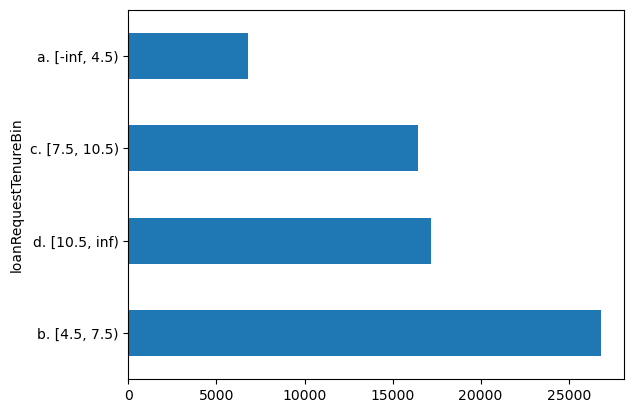

In [233]:
df.loanRequestTenureBin.value_counts().plot(kind = 'barh')

##### Loan Request Tenure Charateristics Stability Index (CSI) Monthly

In [234]:
# Assuming your dataframe is named 'df'
df['Application_month'] = pd.to_datetime(df['Application_month'])
df['year_month'] = df['Application_month'].dt.to_period('M')

# Sort the dataframe by year_month
df = df.sort_values('year_month')

# Get unique monthlyIncomeBins
bins = sorted(df['loanRequestTenureBin'].unique())

# Get the data for April 2024
April2024_data = df[df['year_month'] == '2024-04']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyIncomeBin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['loanRequestTenureBin'] == bin]['loanRequestTenure']
        
        for name, group in df[(df['year_month'] > '2024-04')].groupby('year_month'):
            current_month_bin = group[group['loanRequestTenureBin'] == bin]['loanRequestTenure']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'year_month': name,
                'loanRequestTenureBin': bin,
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['loanRequestTenureBin', 'year_month'])  # Sort results by monthlyIncomeBin and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='loanRequestTenureBin', columns='year_month', values='csi')
pivot_df

   year_month loanRequestTenureBin       csi
0     2024-05       a. [-inf, 4.5)  0.000483
1     2024-06       a. [-inf, 4.5)  0.001774
2     2024-07       a. [-inf, 4.5)  0.025337
3     2024-05        b. [4.5, 7.5)  0.003234
4     2024-06        b. [4.5, 7.5)  0.029664
5     2024-07        b. [4.5, 7.5)  0.001205
6     2024-05       c. [7.5, 10.5)  0.005989
7     2024-06       c. [7.5, 10.5)  0.026547
8     2024-07       c. [7.5, 10.5)  0.001575
9     2024-05       d. [10.5, inf)  0.011700
10    2024-06       d. [10.5, inf)  0.017180
11    2024-07       d. [10.5, inf)  0.005387


year_month,2024-05,2024-06,2024-07
loanRequestTenureBin,,,
"a. [-inf, 4.5)",0.000483,0.001774,0.025337
"b. [4.5, 7.5)",0.003234,0.029664,0.001205
"c. [7.5, 10.5)",0.005989,0.026547,0.001575
"d. [10.5, inf)",0.011700,0.017180,0.005387


In [235]:
csi_df['Score_Category'] = 'Loan Request Tenure - Demographic Score 2024'
csi_df['Date_Category'] = 'Monthly'
csi_df['Feature'] = 'Loan Request Tenure'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['year_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['year_month'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'loanRequestTenureBin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'loanRequestTenureBin':'Band'}, inplace = True)
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-05-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"a. [-inf, 4.5)",Monthly,0.000483
1,2024-06-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"a. [-inf, 4.5)",Monthly,0.001774
2,2024-07-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"a. [-inf, 4.5)",Monthly,0.025337
3,2024-05-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"b. [4.5, 7.5)",Monthly,0.003234
4,2024-06-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"b. [4.5, 7.5)",Monthly,0.029664
5,2024-07-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"b. [4.5, 7.5)",Monthly,0.001205
6,2024-05-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"c. [7.5, 10.5)",Monthly,0.005989
7,2024-06-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"c. [7.5, 10.5)",Monthly,0.026547
8,2024-07-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"c. [7.5, 10.5)",Monthly,0.001575
9,2024-05-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"d. [10.5, inf)",Monthly,0.011700


##### Insert into F_CSI_TT

In [236]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=dcfcf1ca-ba58-492f-a237-9caf6d15db00>

##### Loan Request Tenure Charateristics Stability Index (CSI) Weekly

In [237]:

# Convert 'Appl_week_start_date' to datetime
df['Appl_week_start_date'] = pd.to_datetime(df['Appl_week_start_date'])


# Sort the dataframe by year_month
df = df.sort_values('Appl_week_start_date')


# Get unique monthlyIncomeBins
bins = sorted(df['loanRequestTenureBin'].unique())


# Get the data for April 2024
April2024_data = df[df['Appl_week_start_date'] == '2024-04-01']

# Check if April 2024 data exists
if April2024_data.empty:
    print("Error: No data found for April 2024")
else:
    # Calculate CSI for each monthlyincomebin, comparing April 2024 with each subsequent month
    csi_results = []
    for bin in bins:
        April2024_bin = April2024_data[April2024_data['loanRequestTenureBin'] == bin]['loanRequestTenure']
                
        for name, group in df[(df['Appl_week_start_date'] > '2024-04-01')].groupby('Appl_week_start_date'):
            current_month_bin = group[group['loanRequestTenureBin'] == bin]['loanRequestTenure']
            
            csi_value = calculate_csi_monthlyIncome(April2024_bin, current_month_bin)
            
            csi_results.append({
                'Appl_week_start_date': name,
                'loanRequestTenureBin': f'({bin}]',
                'csi': csi_value
            })

    if not csi_results:
        print("No valid months found for comparison")
    else:
        csi_df = pd.DataFrame(csi_results)
        csi_df = csi_df.sort_values(['loanRequestTenureBin', 'Appl_week_start_date'])  # Sort results by credolabscoreband and year_month
        print(csi_df)

# If you want to pivot the results for easier viewing
pivot_df = csi_df.pivot(index='loanRequestTenureBin', columns='Appl_week_start_date', values='csi')
pivot_df

   Appl_week_start_date loanRequestTenureBin       csi
0            2024-04-08     (a. [-inf, 4.5)]  0.000369
1            2024-04-15     (a. [-inf, 4.5)]  0.000679
2            2024-04-22     (a. [-inf, 4.5)]  0.039211
3            2024-04-29     (a. [-inf, 4.5)]  0.055321
4            2024-05-06     (a. [-inf, 4.5)]  0.000173
..                  ...                  ...       ...
59           2024-06-24     (d. [10.5, inf)]  0.152136
60           2024-07-01     (d. [10.5, inf)]  0.176280
61           2024-07-08     (d. [10.5, inf)]  0.186286
62           2024-07-15     (d. [10.5, inf)]  0.160447
63           2024-07-22     (d. [10.5, inf)]  0.499028

[64 rows x 3 columns]


Appl_week_start_date,2024-04-08,2024-04-15,2024-04-22,2024-04-29,2024-05-06,2024-05-13,2024-05-20,2024-05-27,2024-06-03,2024-06-10,2024-06-17,2024-06-24,2024-07-01,2024-07-08,2024-07-15,2024-07-22
loanRequestTenureBin,,,,,,,,,,,,,,,,
"(a. [-inf, 4.5)]",0.000369,0.000679,0.039211,0.055321,0.000173,0.007607,0.000057,0.001944,0.008813,0.012512,0.001642,0.006754,0.014754,0.003803,0.021445,0.968844
"(b. [4.5, 7.5)]",0.007282,0.042680,0.153675,0.188814,0.040705,0.051099,0.019667,0.113776,0.098684,0.140024,0.106427,0.165548,0.123922,0.134522,0.163275,0.534348
"(c. [7.5, 10.5)]",0.002330,0.068266,0.173739,0.210444,0.070975,0.060331,0.040121,0.072145,0.116536,0.160004,0.127706,0.150641,0.113010,0.142302,0.176602,0.446264
"(d. [10.5, inf)]",0.017853,0.077323,0.265652,0.326453,0.118832,0.126296,0.095757,0.124889,0.135757,0.202440,0.160447,0.152136,0.176280,0.186286,0.160447,0.499028


In [238]:
csi_df['Score_Category'] = 'Loan Request Tenure - Demographic Score 2024'
csi_df['Date_Category'] = 'Weekly'
csi_df['Feature'] = 'Loan Request Tenure'
csi_df['Loan_Product'] = 'SIL'
csi_df['Dated'] = csi_df['Appl_week_start_date'].dt.strftime('%Y-%m-%d')
csi_df.drop(columns=['Appl_week_start_date'], inplace = True)
csi_df = csi_df[['Dated', 'Score_Category', 'Loan_Product','Feature', 'loanRequestTenureBin', 'Date_Category', 'csi']]
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')

csi_df.rename(columns = {'loanRequestTenureBin':'Band'}, inplace = True)
csi_df['Dated'] = pd.to_datetime(csi_df['Dated'], format='%Y-%m-%d')
csi_df

,Dated,Score_Category,Loan_Product,Feature,Band,Date_Category,csi
0,2024-04-08,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(a. [-inf, 4.5)]",Weekly,0.000369
1,2024-04-15,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(a. [-inf, 4.5)]",Weekly,0.000679
2,2024-04-22,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(a. [-inf, 4.5)]",Weekly,0.039211
3,2024-04-29,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(a. [-inf, 4.5)]",Weekly,0.055321
4,2024-05-06,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(a. [-inf, 4.5)]",Weekly,0.000173
...,...,...,...,...,...,...,...
59,2024-06-24,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(d. [10.5, inf)]",Weekly,0.152136
60,2024-07-01,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(d. [10.5, inf)]",Weekly,0.176280
61,2024-07-08,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(d. [10.5, inf)]",Weekly,0.186286
62,2024-07-15,Loan Request Tenure - Demographic Score 2024,SIL,Loan Request Tenure,"(d. [10.5, inf)]",Weekly,0.160447


##### Insert into F_CSI_TT

In [239]:
# Define the dataset and table references
dataset_id = 'dap_ds_poweruser_playground'
table_id = 'F_CSI_TT'
# Define the table schema as per your DataFrame columns
schema = [
    bigquery.SchemaField("Dated", "Date"),
    bigquery.SchemaField("Score_Category", "string"),
    bigquery.SchemaField("Loan_Product", "string"),
    bigquery.SchemaField("Feature", "string"),
    bigquery.SchemaField("Band", "string"),
    bigquery.SchemaField("Date_Category", "string"),
    bigquery.SchemaField("csi", "float64"),
   ]
# Create the dataset reference
dataset_ref = client.dataset(dataset_id)

# Define the table reference
table_ref = dataset_ref.table(table_id)

# Configure the job to overwrite the table if it already exists
job_config = bigquery.LoadJobConfig(schema = schema)

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(csi_df, table_ref, job_config=job_config)

# Wait for the job to complete
job.result()

# print(f"Table {table_id} created in dataset {dataset_id}.")

LoadJob<project=prj-prod-dataplatform, location=asia-southeast1, id=9dbc7603-f78b-4df7-9ad6-4949c5aea80a>